In [1]:
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations

sys.path.append('..')
sns.set_style('whitegrid')

print("✅ Librerías importadas")

✅ Librerías importadas


## 1️⃣ Cargar Datos y Modelo

In [2]:
# Cargar datos
df = pd.read_csv('../data/ames_dum.csv')

# Cargar modelo
with open('../models/xgb_optuna_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Features
trained_feats = model.get_booster().feature_names
X = df[trained_feats].copy()
y_log = df['Sale_Price_Log'].copy()

# Estadísticos
trained_stats = X.describe().T[['min', 'max', '50%']]
trained_stats.columns = ['min', 'max', 'median']
trained_stats['q05'] = X.quantile(0.05)
trained_stats['q95'] = X.quantile(0.95)

print(f"📊 Datos cargados: {len(df)} casas")

📊 Datos cargados: 2930 casas


## 2️⃣ Seleccionar Casa Aleatoria y Obtener Top 3 Variables

In [3]:
from optimizacion_sensible import optimize_house

# Seleccionar casa aleatoria
np.random.seed(42)
casa_idx = np.random.randint(0, len(df))

print(f"🏠 Casa seleccionada: #{casa_idx}")
print(f"   Precio actual: ${np.expm1(y_log.iloc[casa_idx]):,.0f}")

# Ejecutar optimización base
BASE_PARAMS = {
    'model': model,
    'X': X,
    'y_log': y_log,
    'trained_feats': trained_feats,
    'trained_stats': trained_stats,
    'baseline_idx': casa_idx,
    'budget': 50000,
    'pwl_k': 25,
    'zero': False
}

print(f"\n🔍 Ejecutando optimización base...")
result_base = optimize_house(**BASE_PARAMS)

if result_base:
    print(f"\n✅ Optimización completada:")
    print(f"   Precio inicial: ${result_base['price_before']:,.0f}")
    print(f"   Precio final:   ${result_base['price_after']:,.0f}")
    print(f"   Inversión:      ${result_base['spent']:,.0f}")
    print(f"   Ganancia:       ${result_base['profit']:,.0f}")
    print(f"   ROI:            {result_base['roi']:.2%}")
    print(f"   Cambios:        {result_base['num_changes']}")

🏠 Casa seleccionada: #860
   Precio actual: $203,434

🔍 Ejecutando optimización base...

OPTIMIZACIÓN CASA ÓPTIMA

Casa 860 seleccionada como baseline
Precio predicho: 206,510 | Precio real: 203,434
Set parameter Username

--------------------------------------------
--------------------------------------------

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2025-11-27

Academic license - for non-commercial use only - expires 2025-11-27
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2732 rows, 13646 columns and 15485 nonzeros
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50

In [4]:
# Identificar top 3 variables con mayor cambio
changes = result_base['changes']
changes_abs = {k: abs(v) for k, v in changes.items() if abs(v) > 0.01}
top_3_vars = sorted(changes_abs.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"\n🎯 TOP 3 VARIABLES CON MAYOR CAMBIO:")
print("="*70)
for i, (var, change_abs) in enumerate(top_3_vars, 1):
    change_original = changes[var]
    cost = result_base['cost_breakdown'].get(var, 0)
    print(f"{i}. {var}")
    print(f"   Cambio:  {change_original:+.2f} unidades")
    print(f"   Costo:   ${cost:,.0f}")
    print()

# Guardar las 3 variables
top_vars = [var for var, _ in top_3_vars]
print(f"Variables a analizar: {top_vars}")


🎯 TOP 3 VARIABLES CON MAYOR CAMBIO:
1. First_Flr_SF
   Cambio:  +138.00 unidades
   Costo:   $20,838

2. Wood_Deck_SF
   Cambio:  +65.00 unidades
   Costo:   $650

3. Open_Porch_SF
   Cambio:  +31.00 unidades
   Costo:   $3,441

Variables a analizar: ['First_Flr_SF', 'Wood_Deck_SF', 'Open_Porch_SF']


## 3️⃣ Análisis de Sensibilidad Individual

Variamos el costo de cada variable individualmente con factores de 0.5x a 3.0x

In [5]:
# Factores de costo a probar
cost_factors = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]

# Resultados por variable
results_individual = {var: {} for var in top_vars}

print("="*80)
print("🔬 ANÁLISIS DE SENSIBILIDAD INDIVIDUAL")
print("="*80)

for var in top_vars:
    print(f"\n{'='*80}")
    print(f"📊 Variable: {var}")
    print(f"{'='*80}")
    
    for factor in cost_factors:
        print(f"\n   Factor {factor}x...", end=" ")
        
        params = BASE_PARAMS.copy()
        params['custom_costs'] = {var: factor}
        
        result = optimize_house(**params)
        
        if result and 'profit' in result:
            results_individual[var][factor] = result
            print(f"✓ ROI: {result['roi']:>6.1%} | Cambio {var}: {result['changes'].get(var, 0):+.2f}")
        else:
            print(f"✗ Error")

print(f"\n{'='*80}")
print("✅ Análisis individual completado")
print("="*80)

🔬 ANÁLISIS DE SENSIBILIDAD INDIVIDUAL

📊 Variable: First_Flr_SF

   Factor 0.5x... 
OPTIMIZACIÓN CASA ÓPTIMA

Casa 860 seleccionada como baseline
Precio predicho: 206,510 | Precio real: 203,434

📌 Multiplicadores aplicados: {'First_Flr_SF': 0.5}
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2732 rows, 13646 columns and 15485 nonzeros
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2732 rows, 13646 columns and 15485 nonzeros
Model fingerprint: 0x3638d8f4
Model has 4 quadratic objective terms
Model has 3 quadratic constraints
Mode

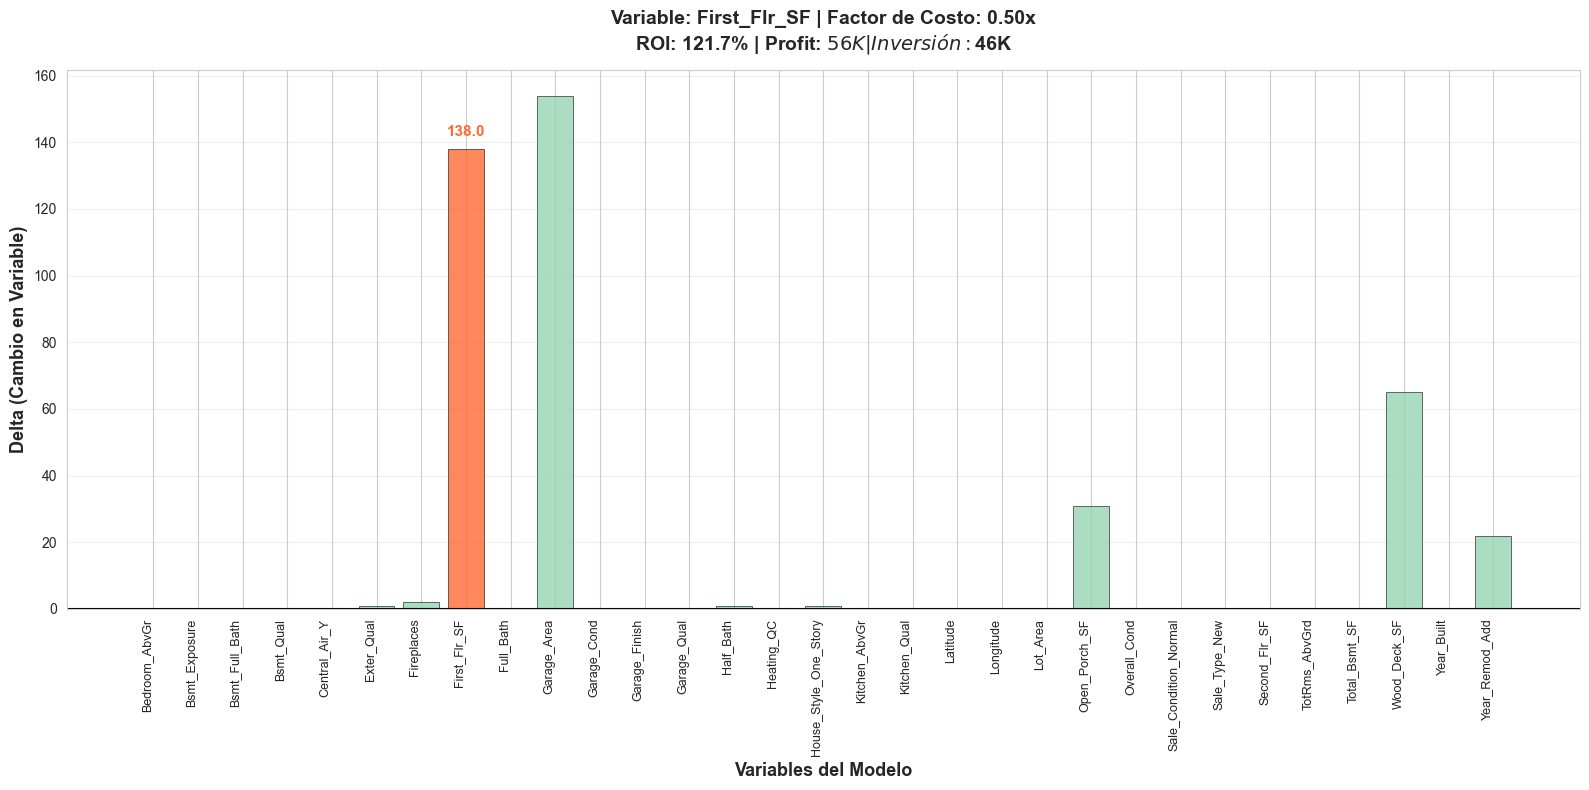

✓ Gráfico: First_Flr_SF con factor 0.50x | ROI: 121.7%


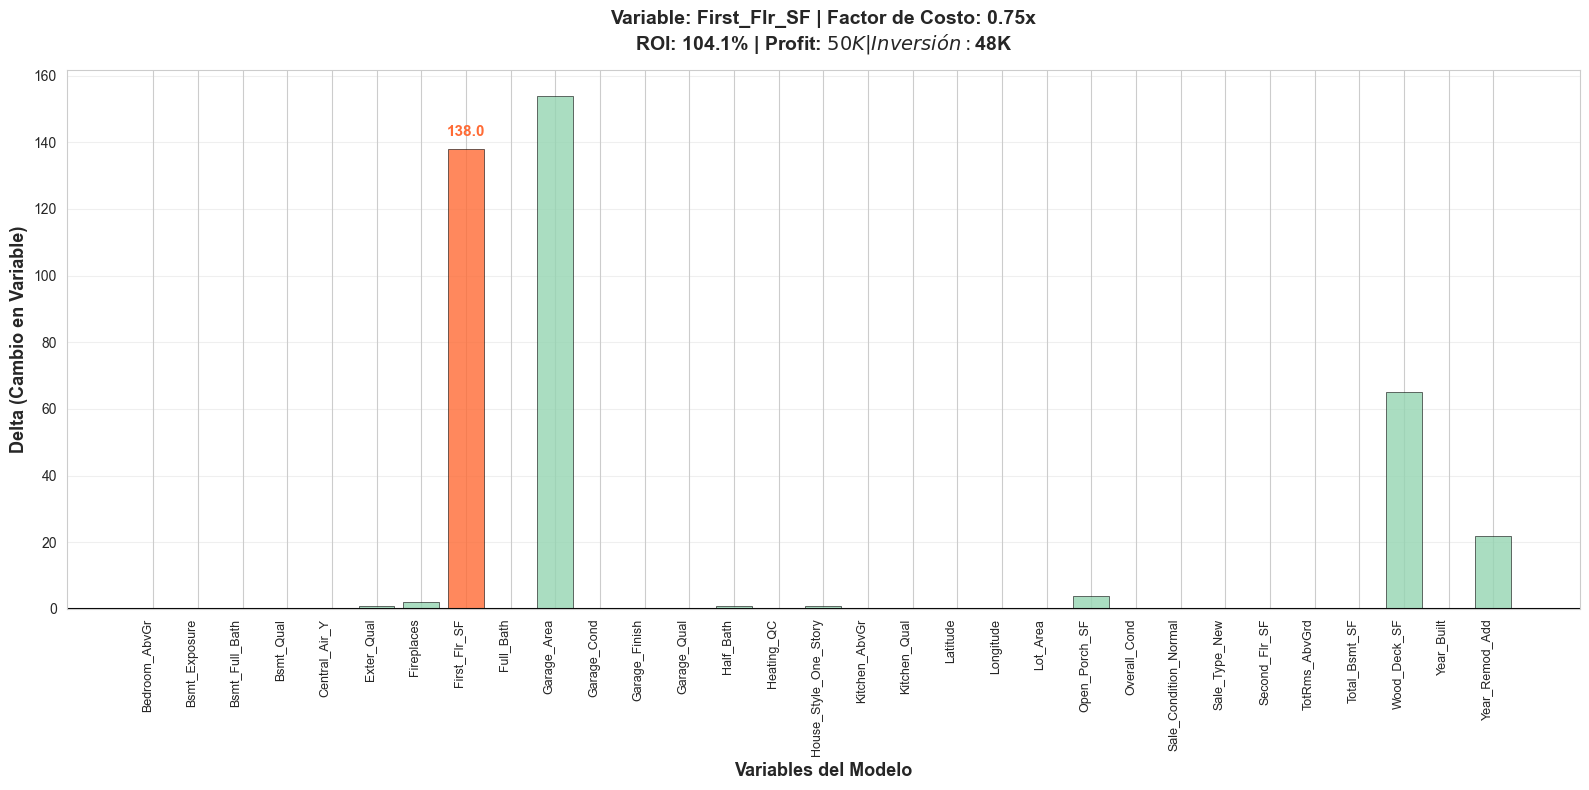

✓ Gráfico: First_Flr_SF con factor 0.75x | ROI: 104.1%


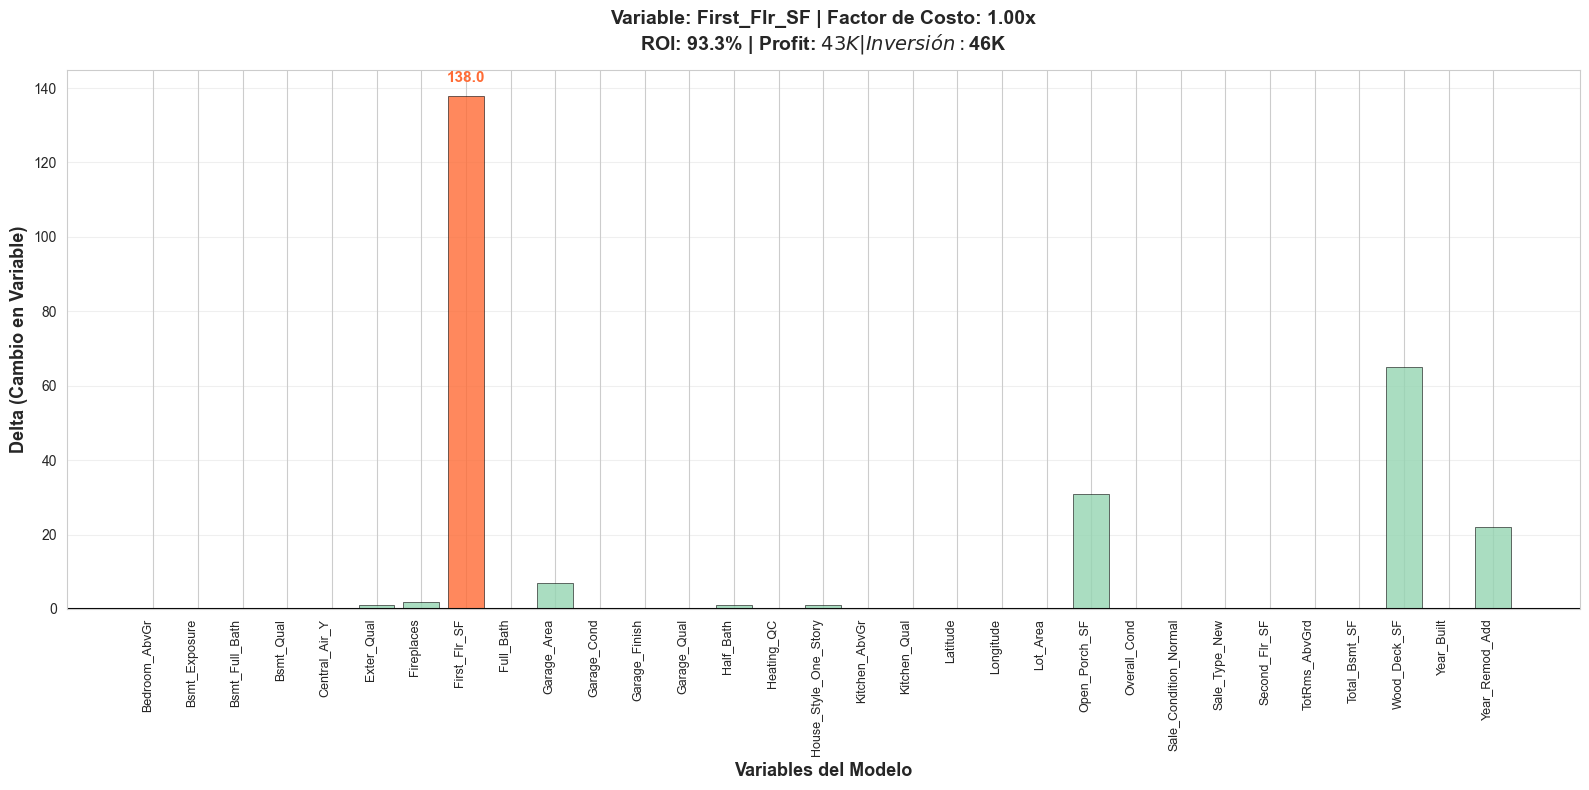

✓ Gráfico: First_Flr_SF con factor 1.00x | ROI: 93.3%


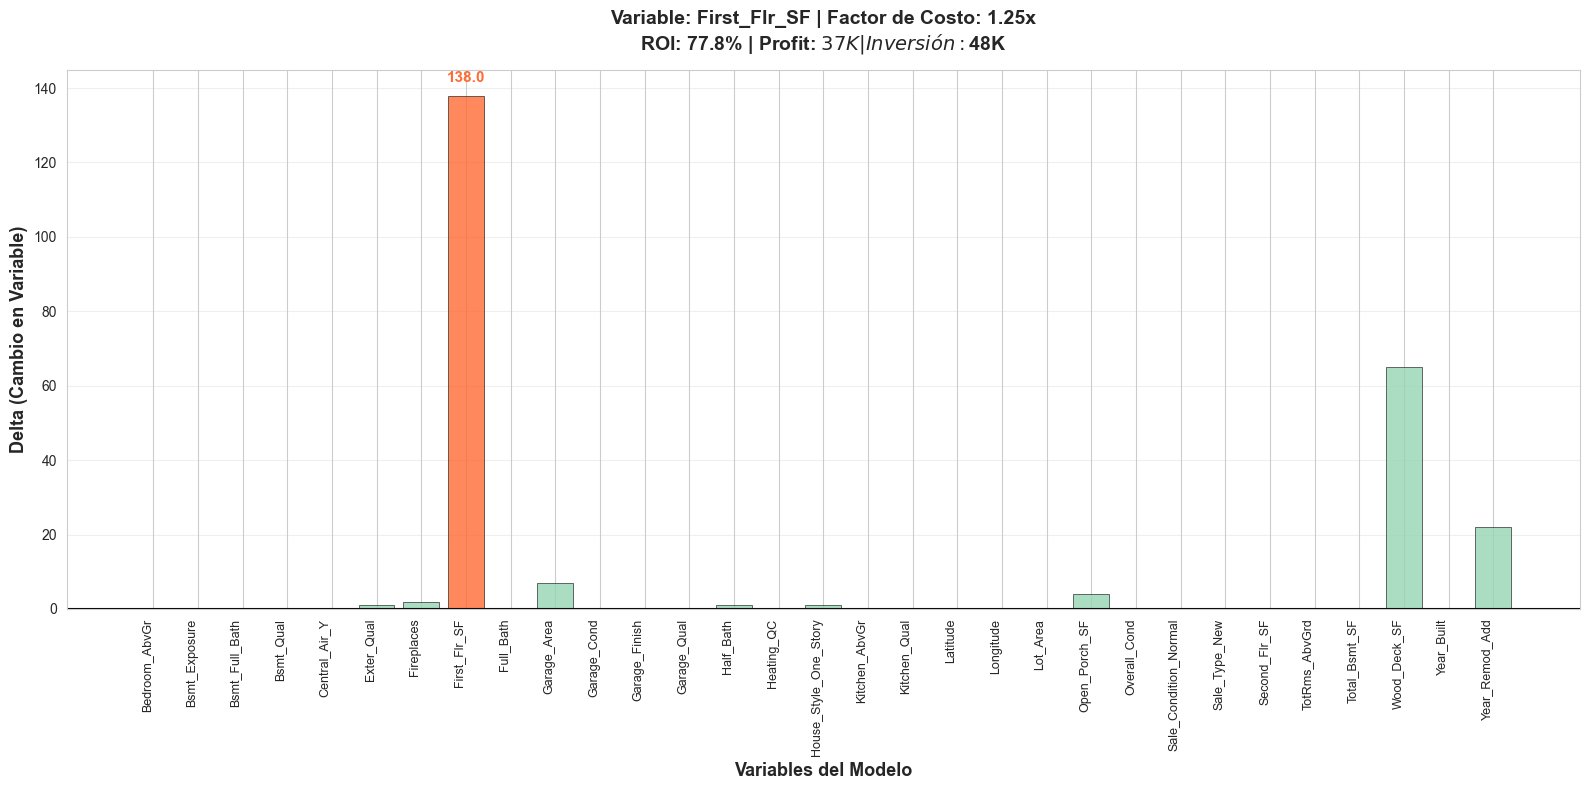

✓ Gráfico: First_Flr_SF con factor 1.25x | ROI: 77.8%


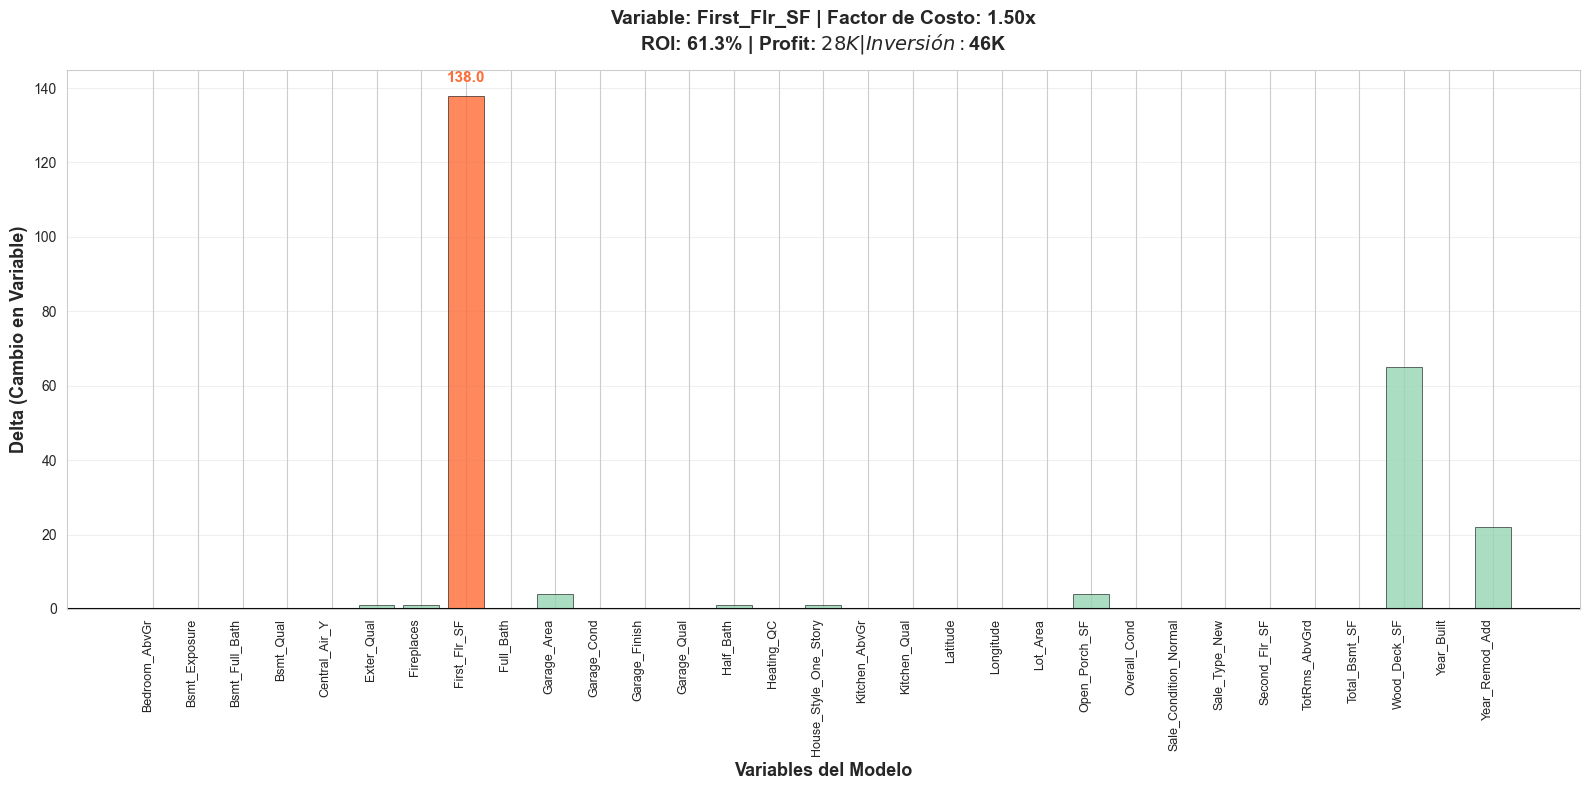

✓ Gráfico: First_Flr_SF con factor 1.50x | ROI: 61.3%


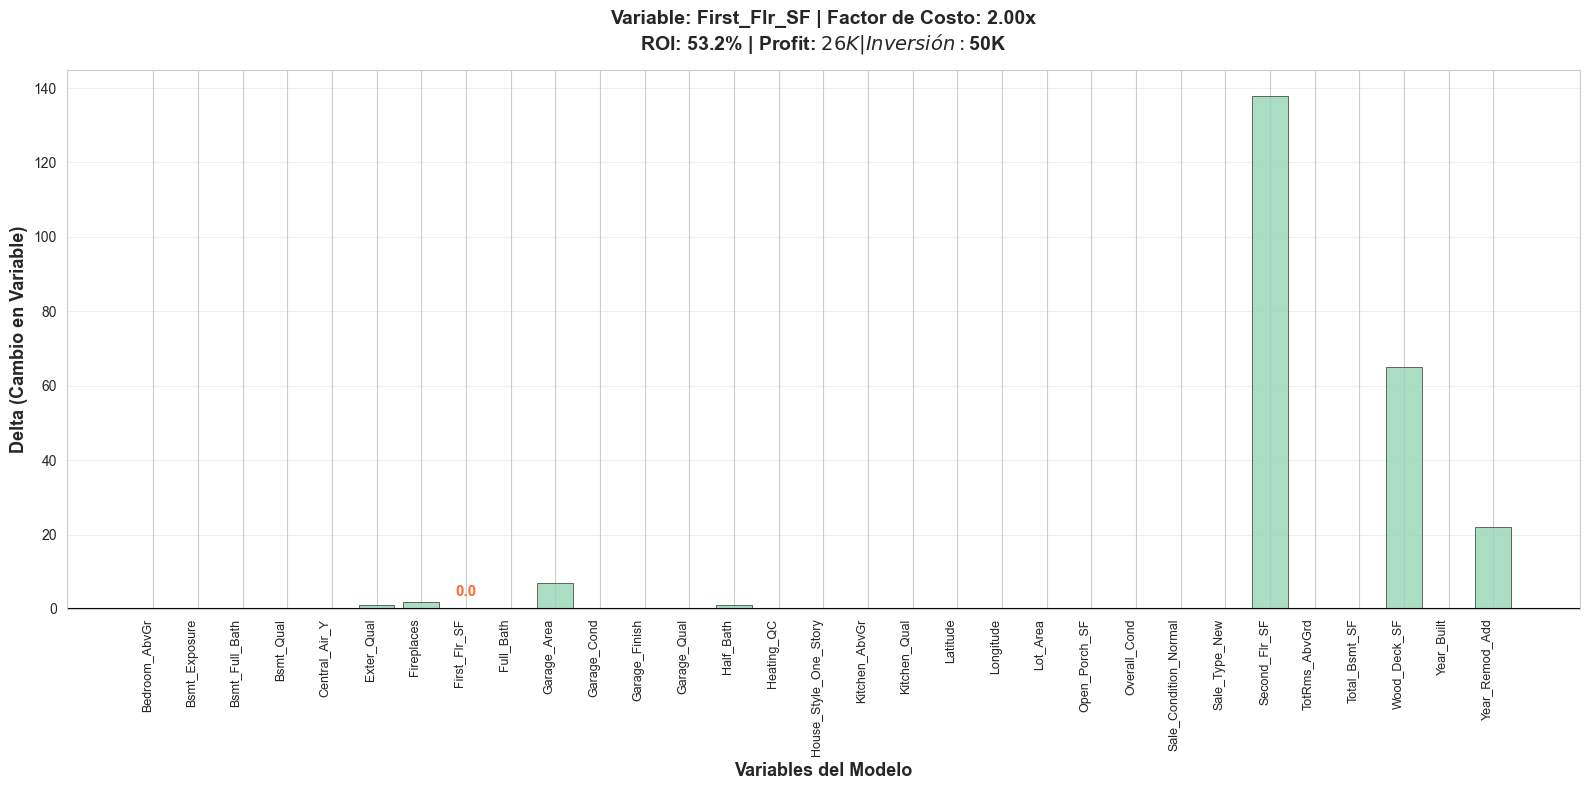

✓ Gráfico: First_Flr_SF con factor 2.00x | ROI: 53.2%


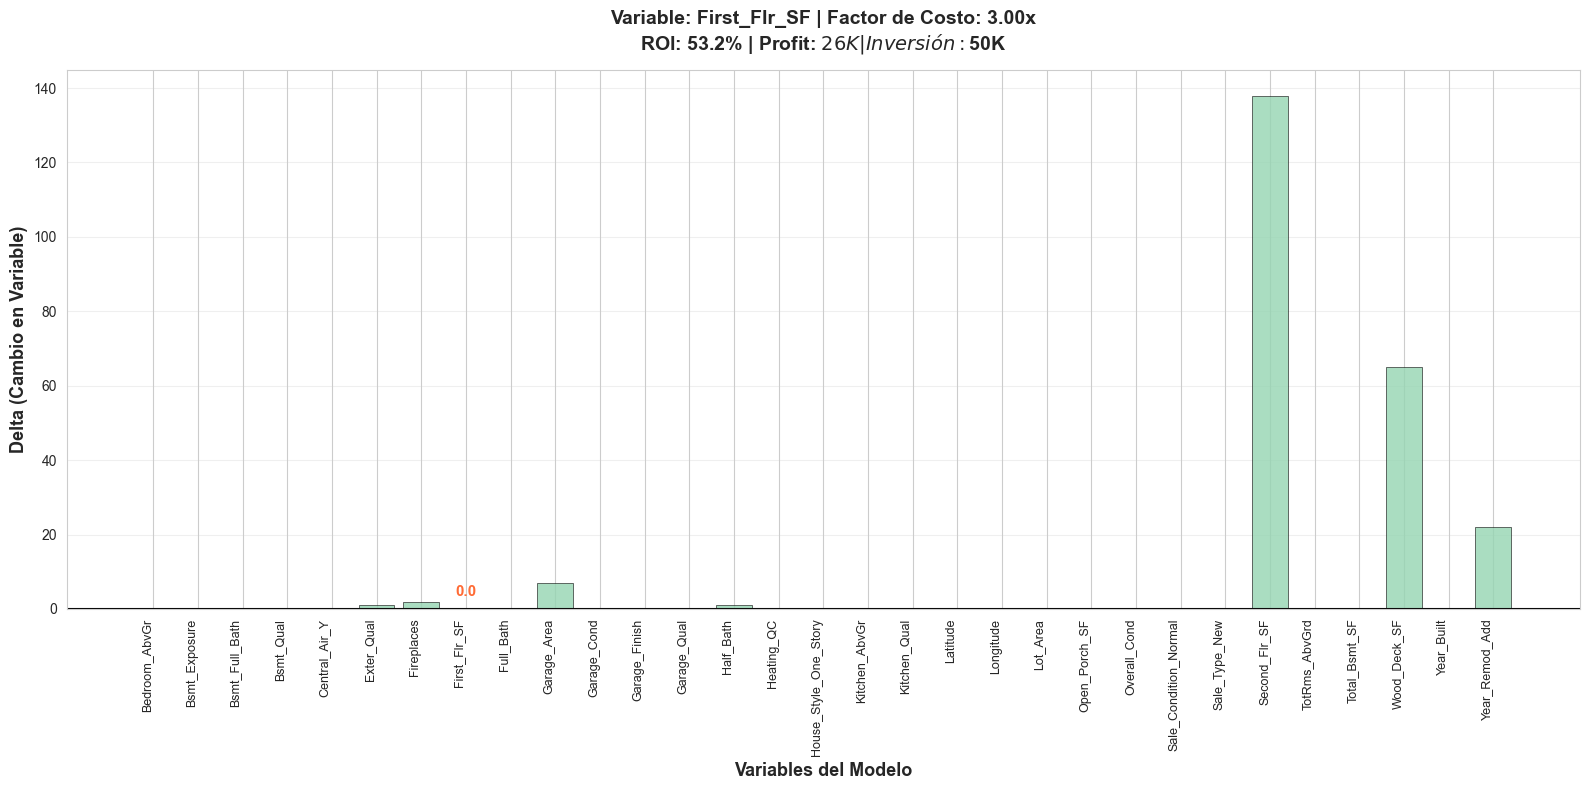

✓ Gráfico: First_Flr_SF con factor 3.00x | ROI: 53.2%


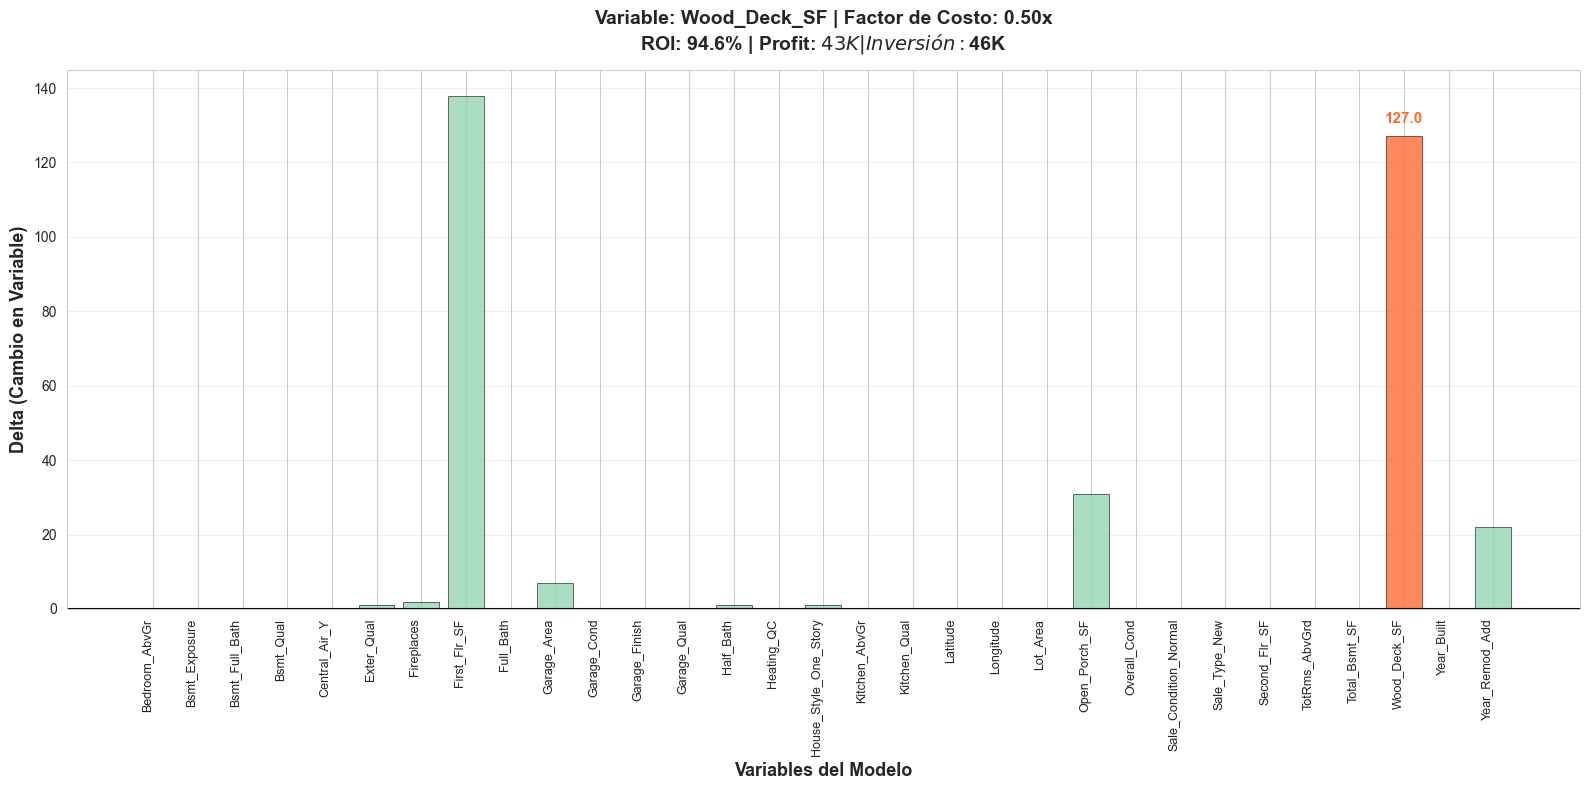

✓ Gráfico: Wood_Deck_SF con factor 0.50x | ROI: 94.6%


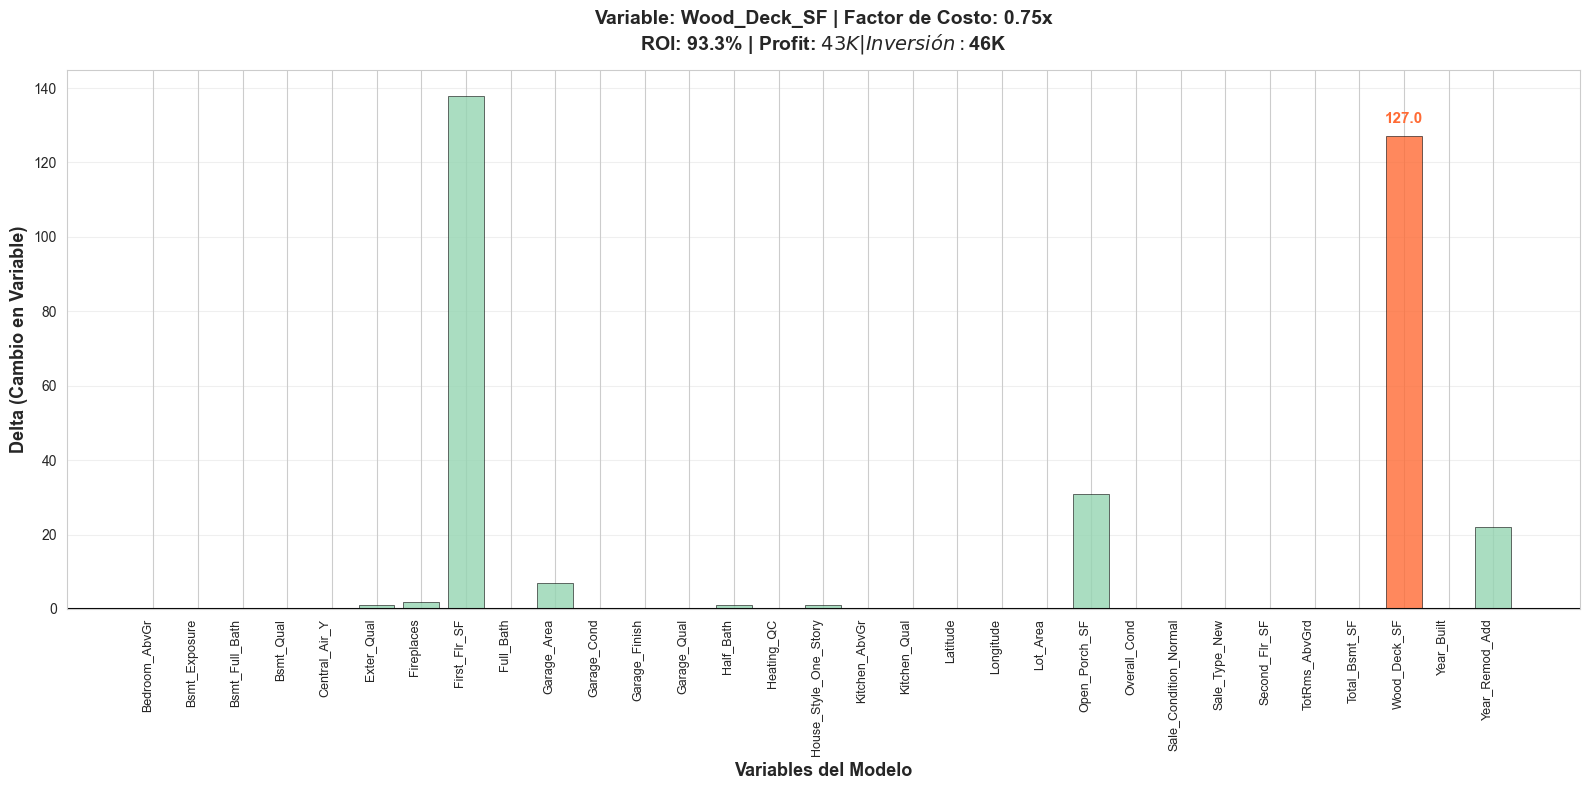

✓ Gráfico: Wood_Deck_SF con factor 0.75x | ROI: 93.3%


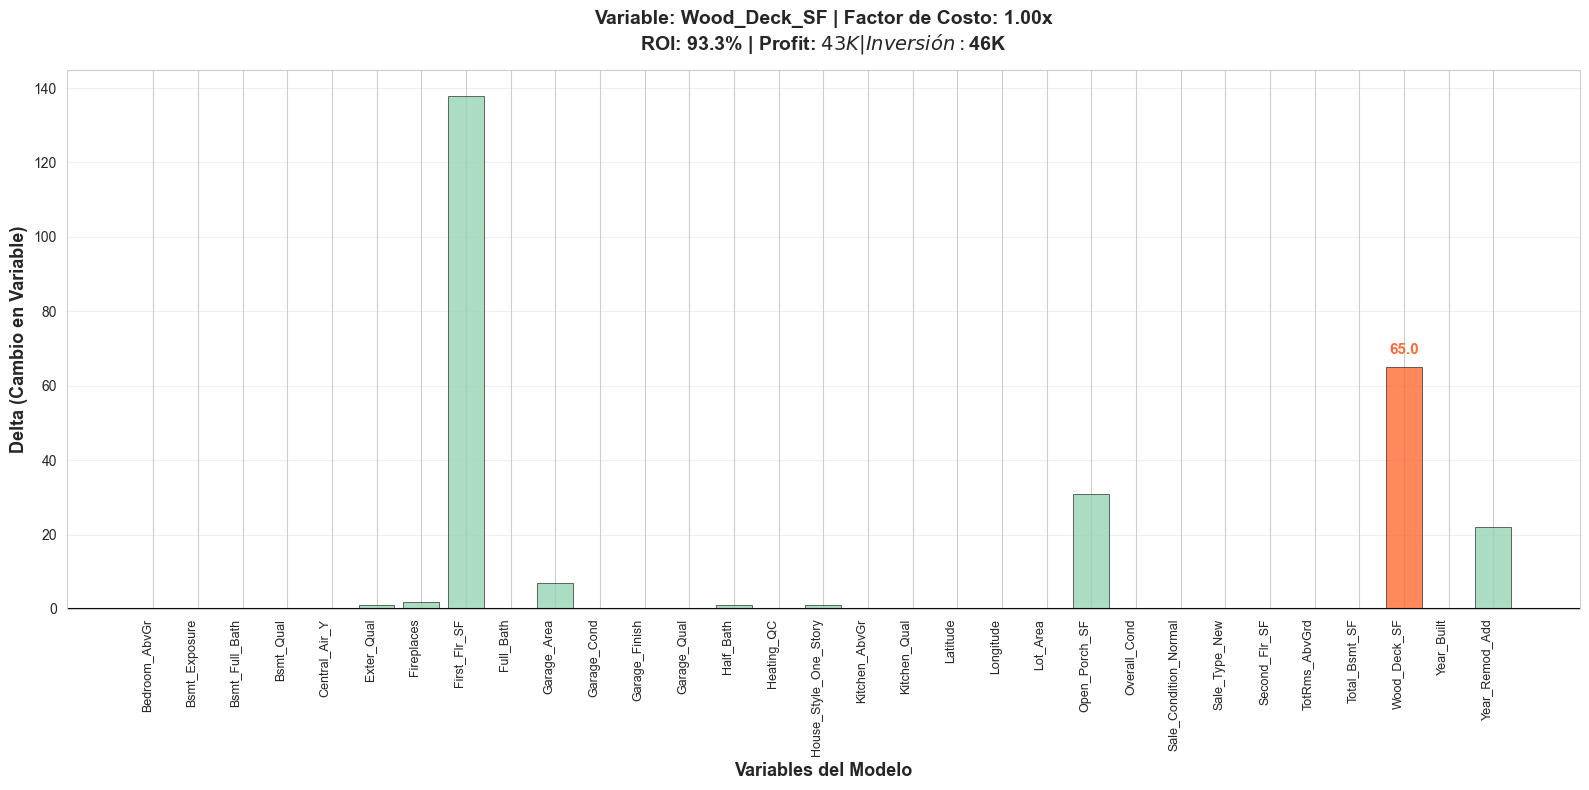

✓ Gráfico: Wood_Deck_SF con factor 1.00x | ROI: 93.3%


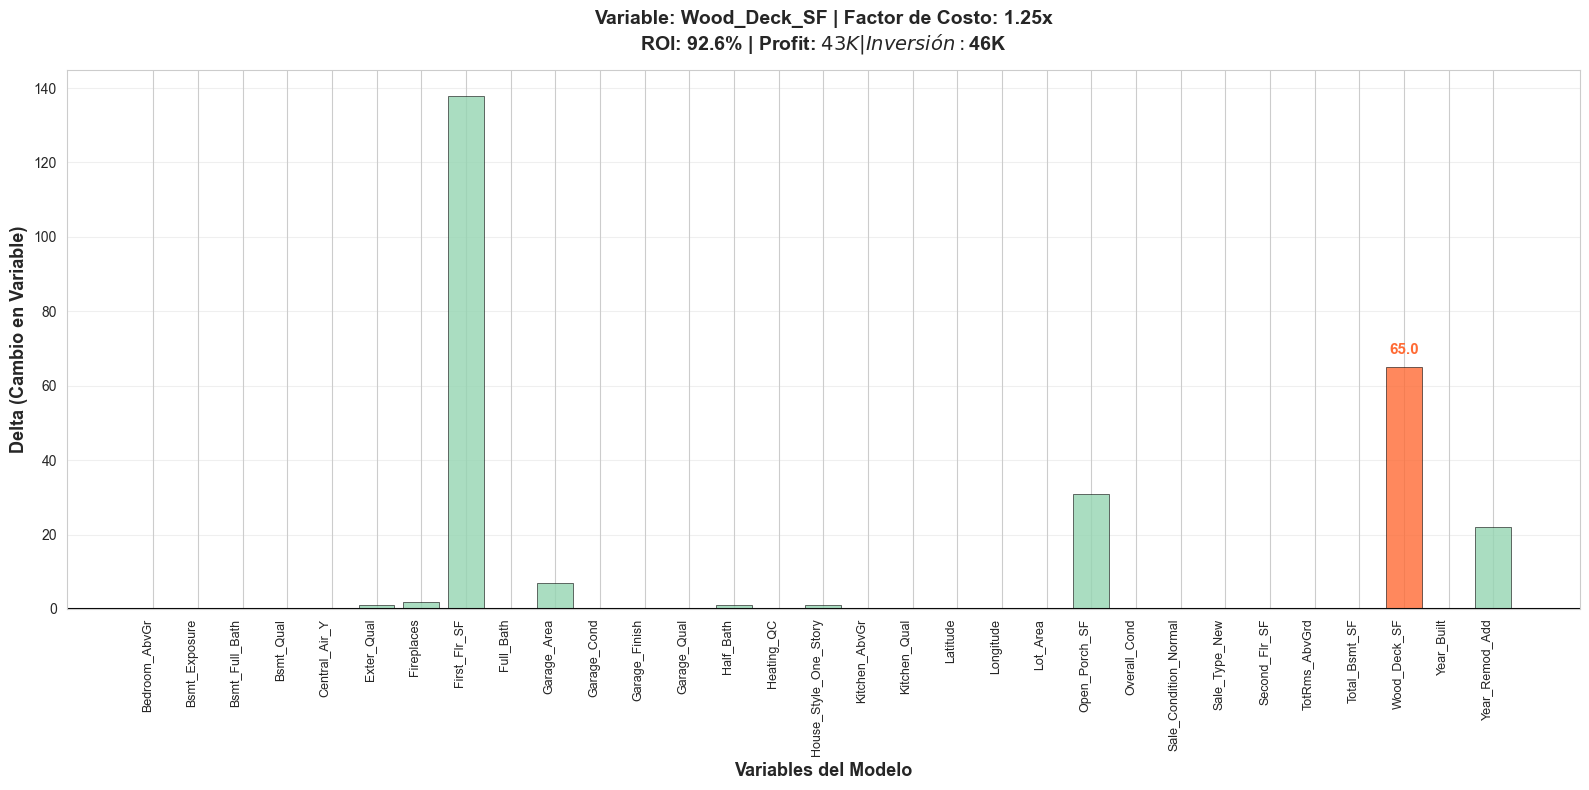

✓ Gráfico: Wood_Deck_SF con factor 1.25x | ROI: 92.6%


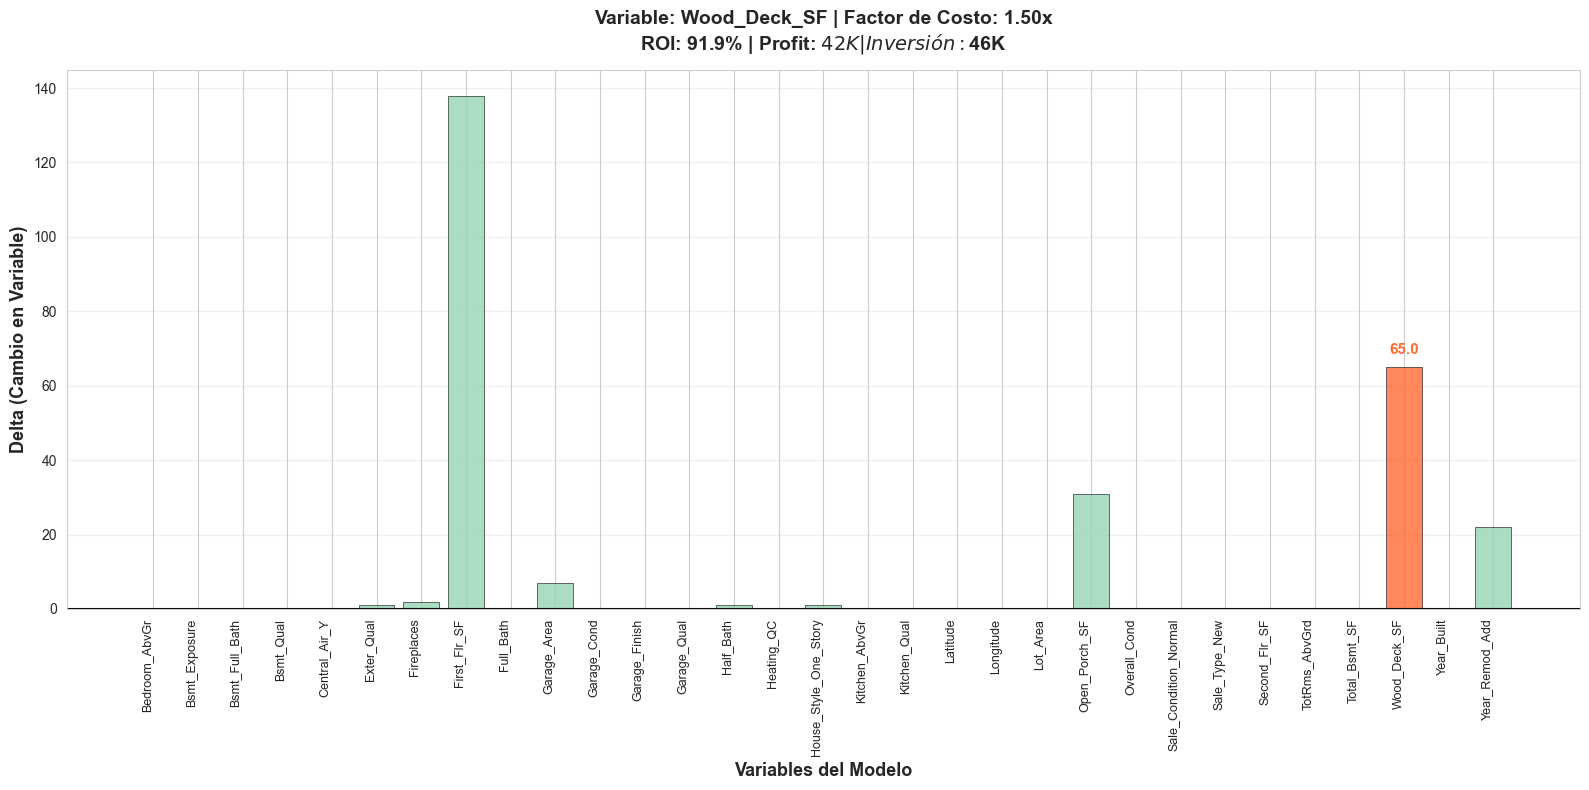

✓ Gráfico: Wood_Deck_SF con factor 1.50x | ROI: 91.9%


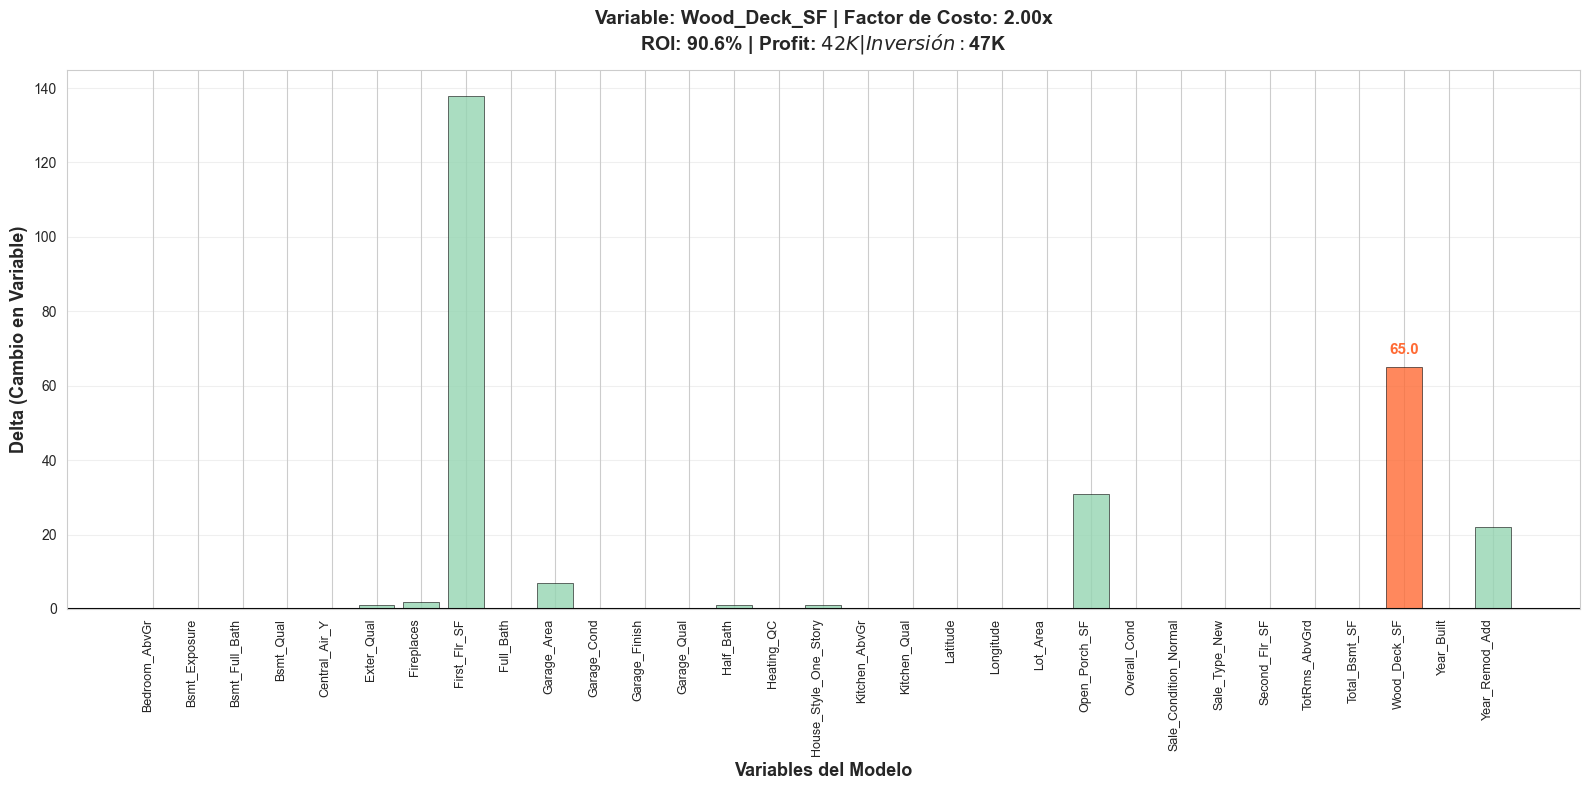

✓ Gráfico: Wood_Deck_SF con factor 2.00x | ROI: 90.6%


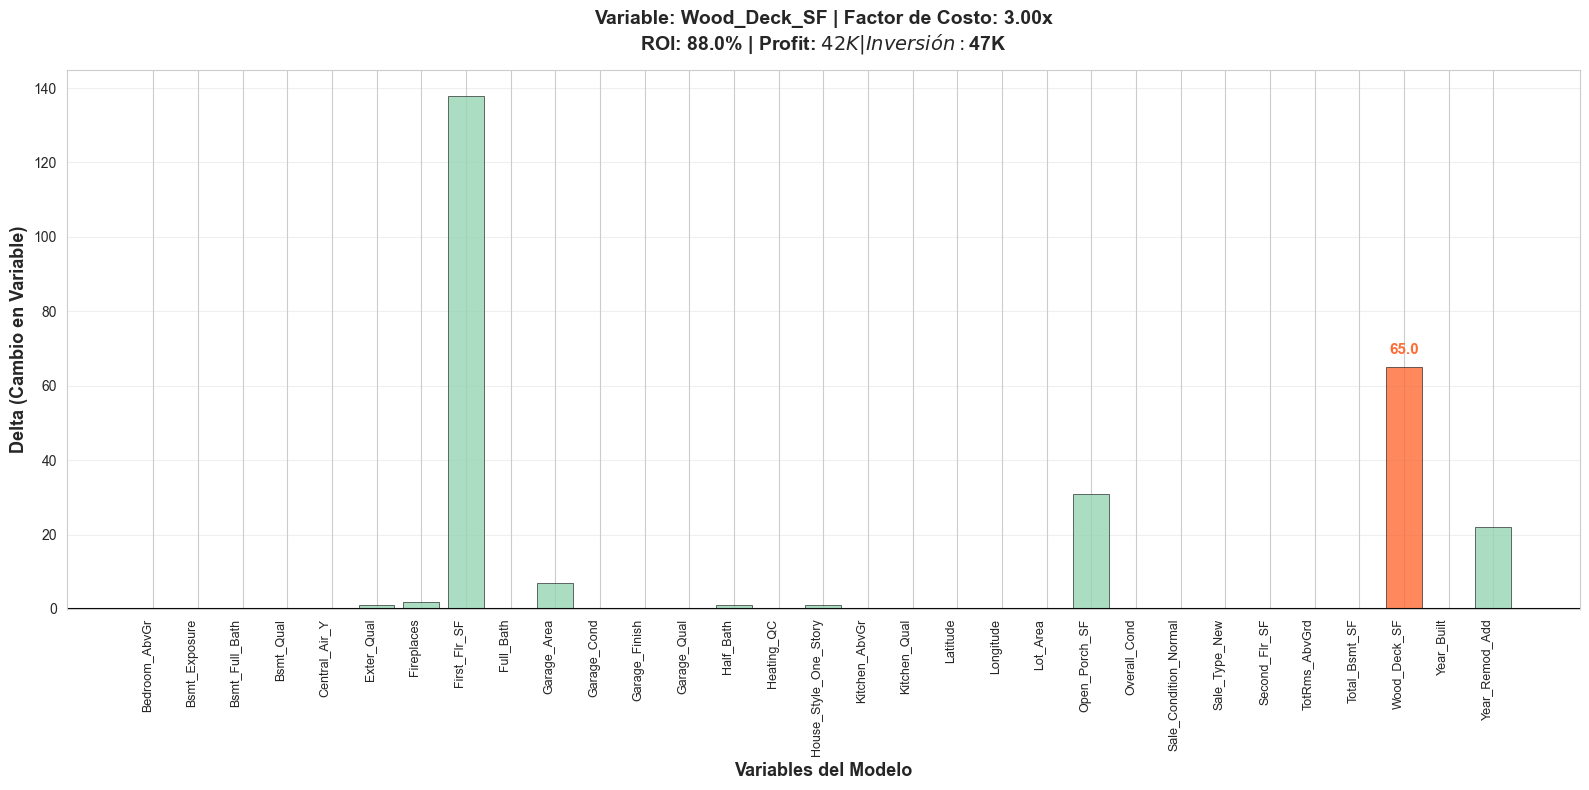

✓ Gráfico: Wood_Deck_SF con factor 3.00x | ROI: 88.0%


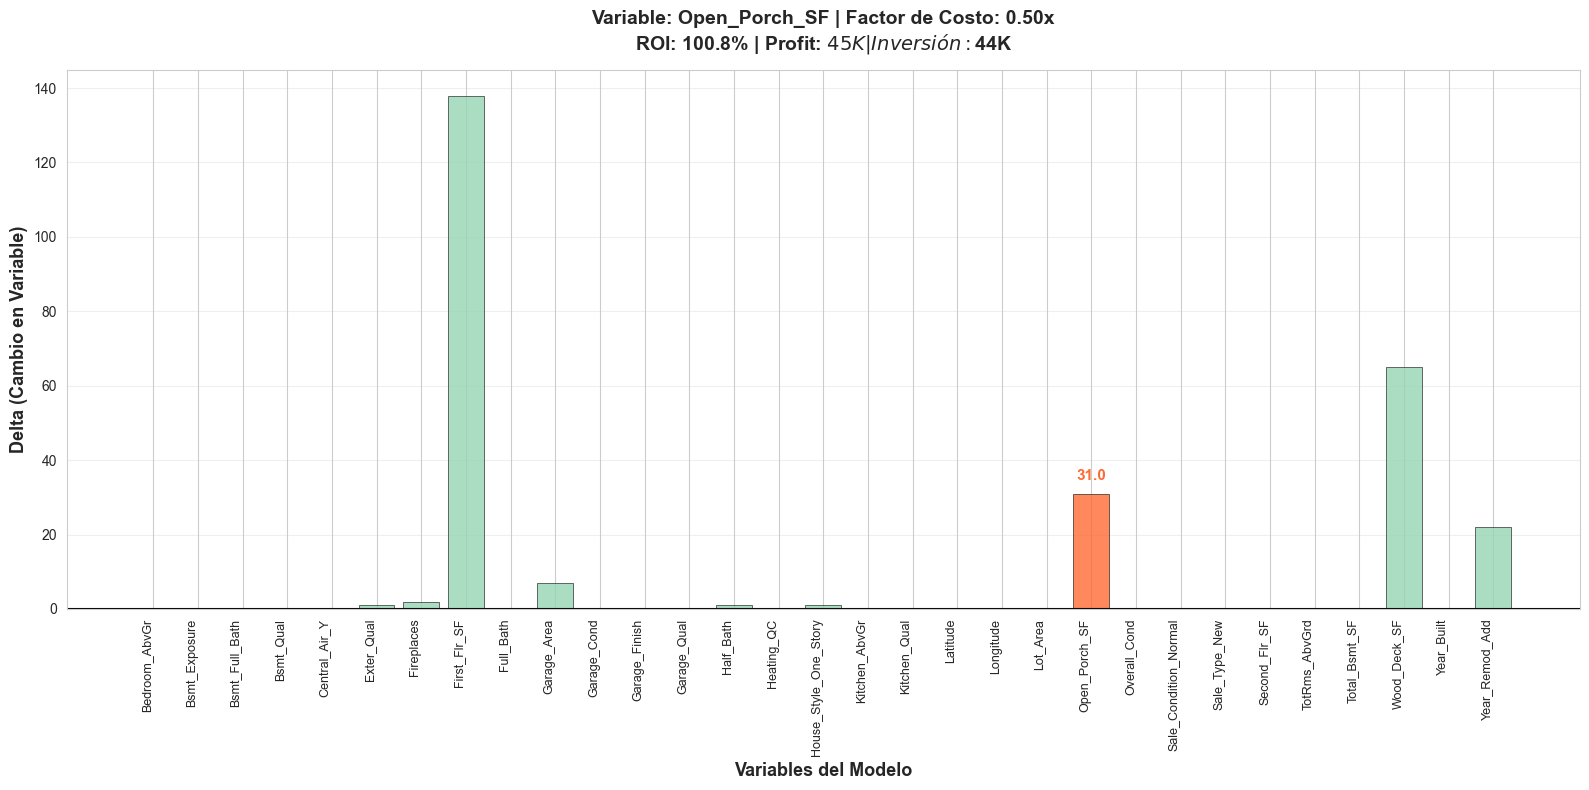

✓ Gráfico: Open_Porch_SF con factor 0.50x | ROI: 100.8%


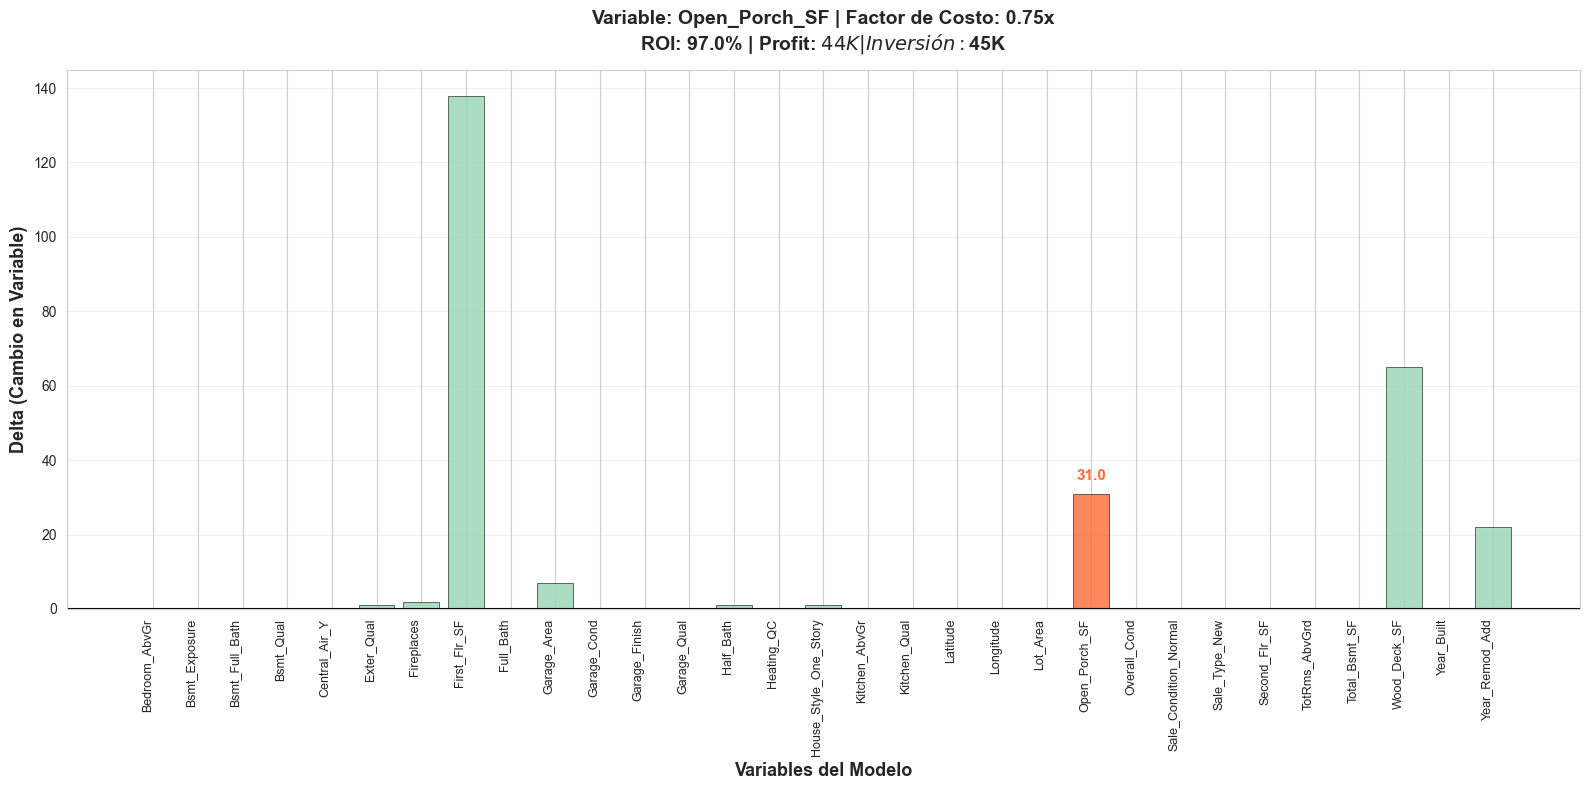

✓ Gráfico: Open_Porch_SF con factor 0.75x | ROI: 97.0%


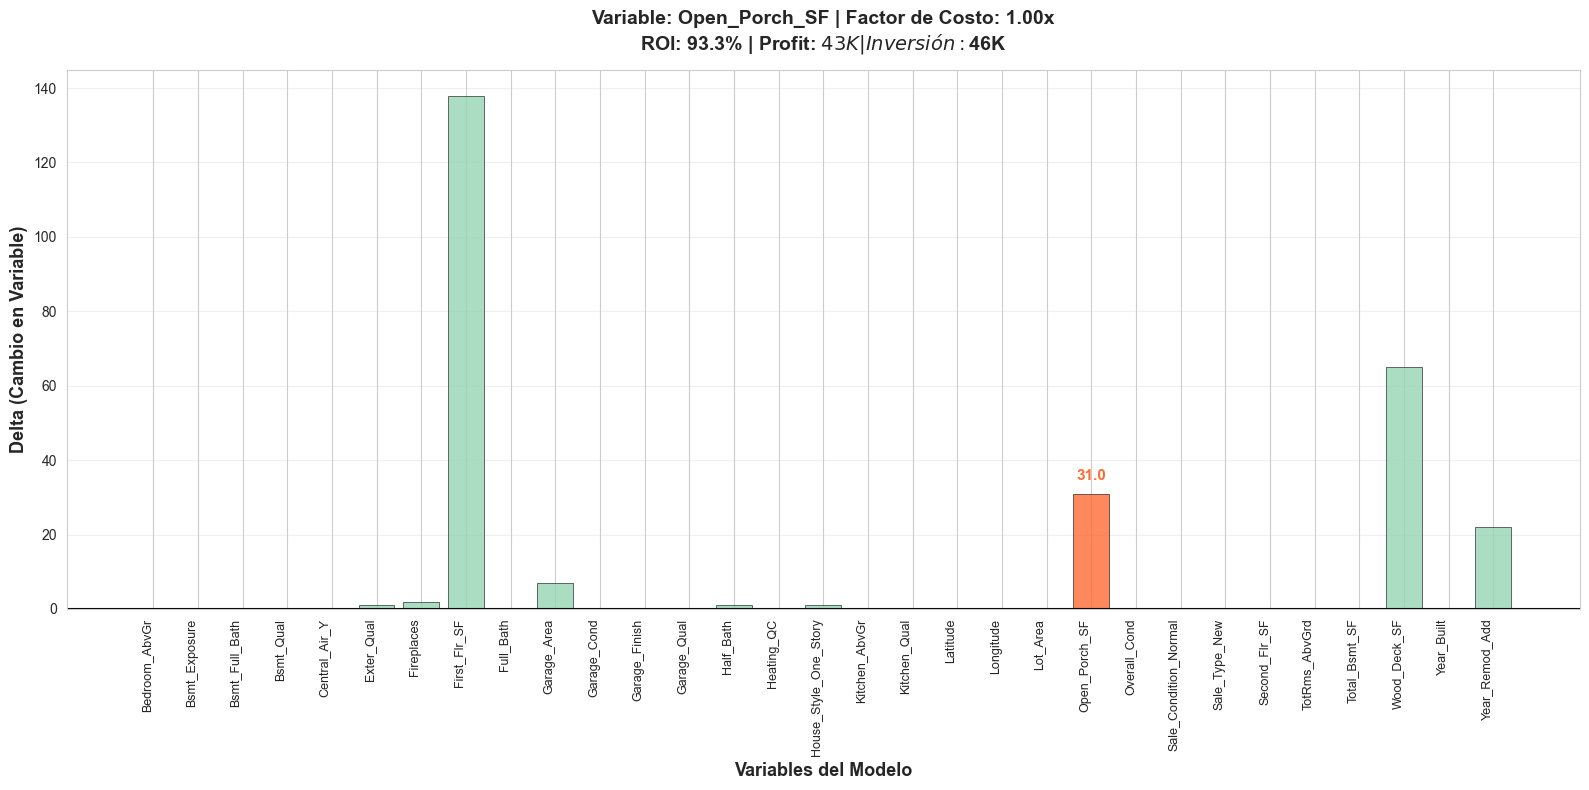

✓ Gráfico: Open_Porch_SF con factor 1.00x | ROI: 93.3%


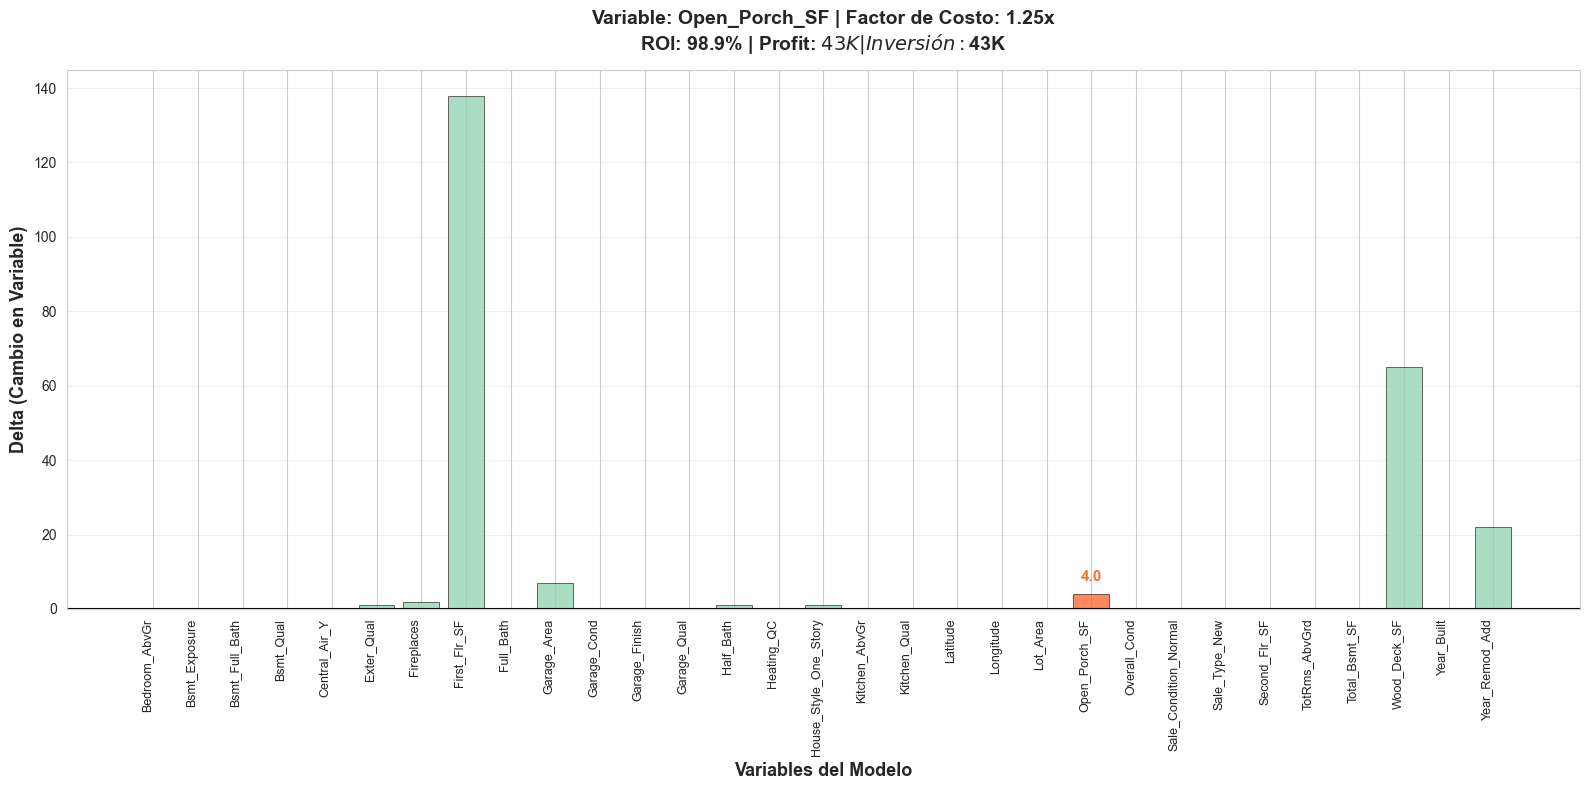

✓ Gráfico: Open_Porch_SF con factor 1.25x | ROI: 98.9%


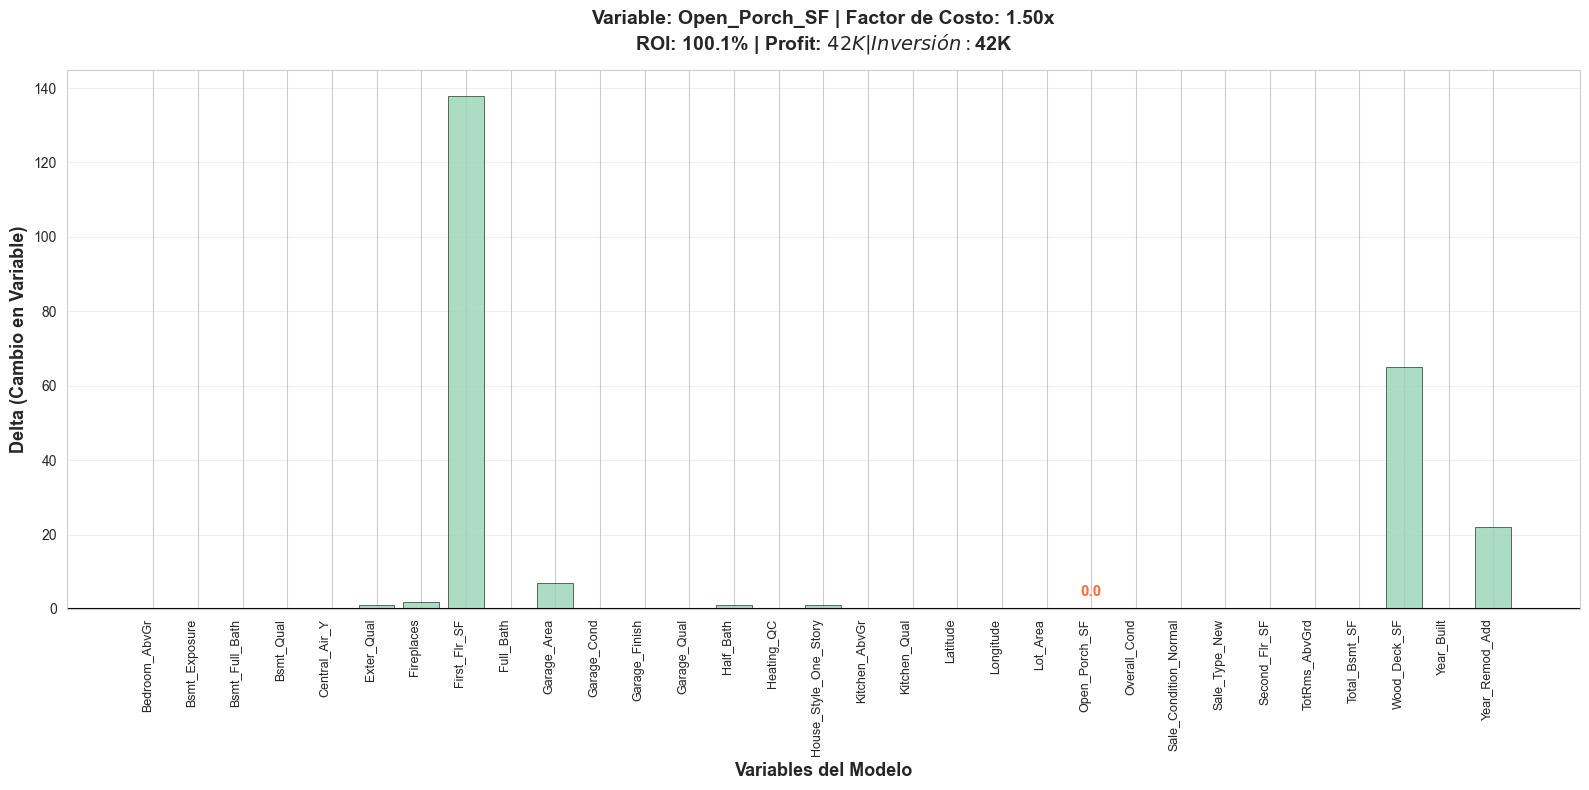

✓ Gráfico: Open_Porch_SF con factor 1.50x | ROI: 100.1%


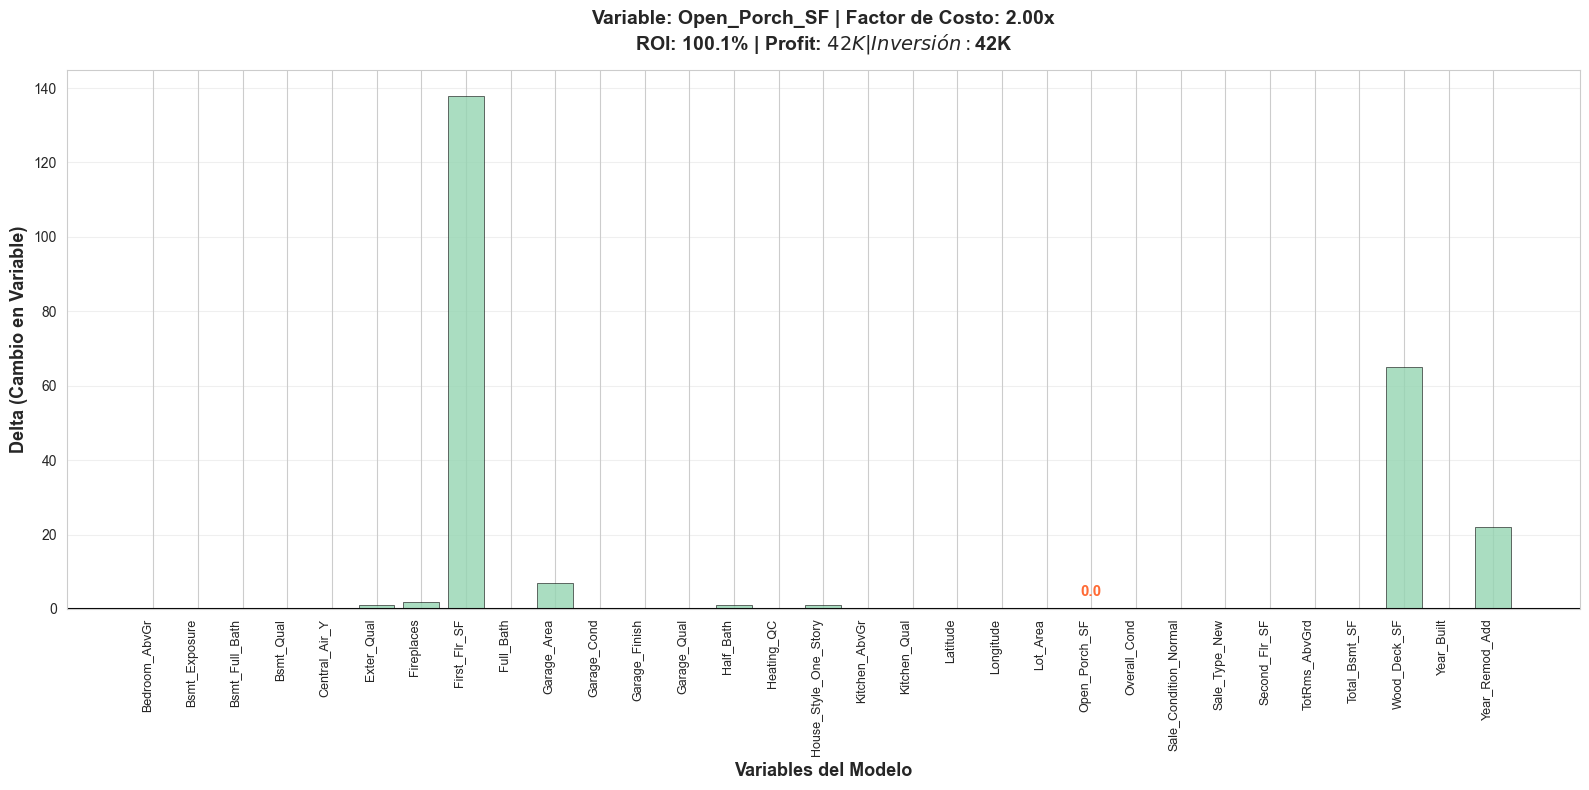

✓ Gráfico: Open_Porch_SF con factor 2.00x | ROI: 100.1%


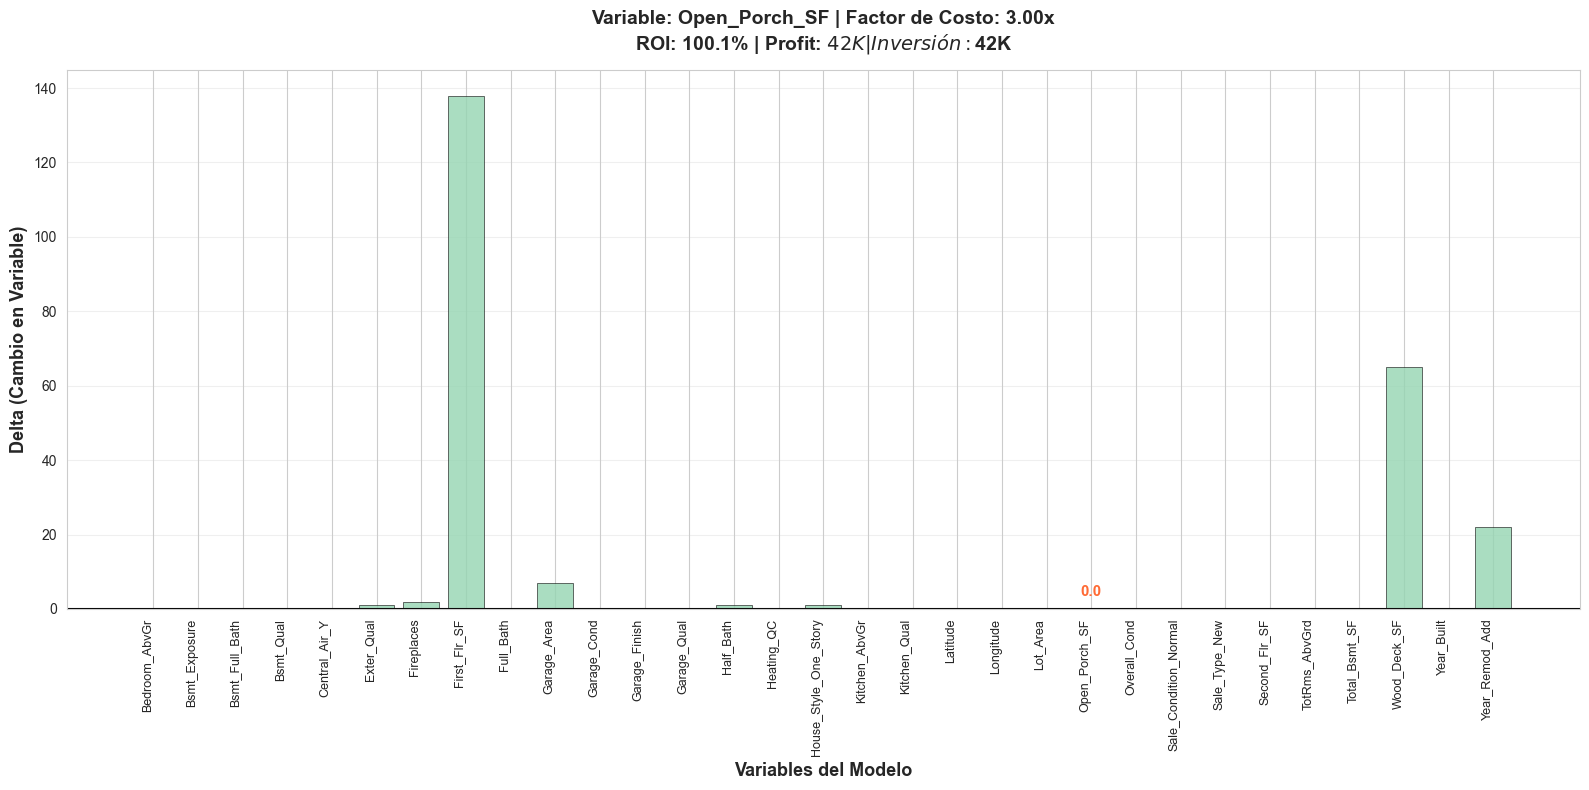

✓ Gráfico: Open_Porch_SF con factor 3.00x | ROI: 100.1%


In [14]:
# Gráficos individuales: un gráfico por cada combinación de variable × factor de costo
# Total: 3 variables × 7 factores = 21 gráficos

for var in top_vars:
    factors = sorted(results_individual[var].keys())
    
    for factor in factors:
        # Crear figura individual
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Obtener cambios de TODAS las variables para este caso específico
        changes = results_individual[var][factor]['changes']
        all_variables = sorted(changes.keys())
        deltas = [changes[v] for v in all_variables]
        
        # Colores: naranja para la variable que variamos, verde para las demás
        colors = ['#FF6B35' if v == var else '#95D5B2' for v in all_variables]
        
        # Crear barras
        x_pos = np.arange(len(all_variables))
        bars = ax.bar(x_pos, deltas, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Línea de referencia en cero
        ax.axhline(0, color='black', linestyle='-', linewidth=1.5)
        
        # Configuración
        ax.set_xlabel('Variables del Modelo', fontsize=13, fontweight='bold')
        ax.set_ylabel('Delta (Cambio en Variable)', fontsize=13, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(all_variables, rotation=90, ha='right', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Métricas del caso
        profit = results_individual[var][factor]['profit']
        roi = results_individual[var][factor]['roi']
        spent = results_individual[var][factor]['spent']
        
        # Título con información completa
        ax.set_title(f'Variable: {var} | Factor de Costo: {factor:.2f}x\n' + 
                     f'ROI: {roi:.1%} | Profit: ${profit/1000:.0f}K | Inversión: ${spent/1000:.0f}K',
                     fontsize=14, fontweight='bold', pad=15)
        
        # Destacar la variable que estamos variando
        var_idx = all_variables.index(var)
        ax.text(var_idx, deltas[var_idx] + (max(deltas) - min(deltas)) * 0.02,
                f'{deltas[var_idx]:.1f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='#FF6B35')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Gráfico: {var} con factor {factor:.2f}x | ROI: {roi:.1%}")


## 4️⃣ Visualización Individual

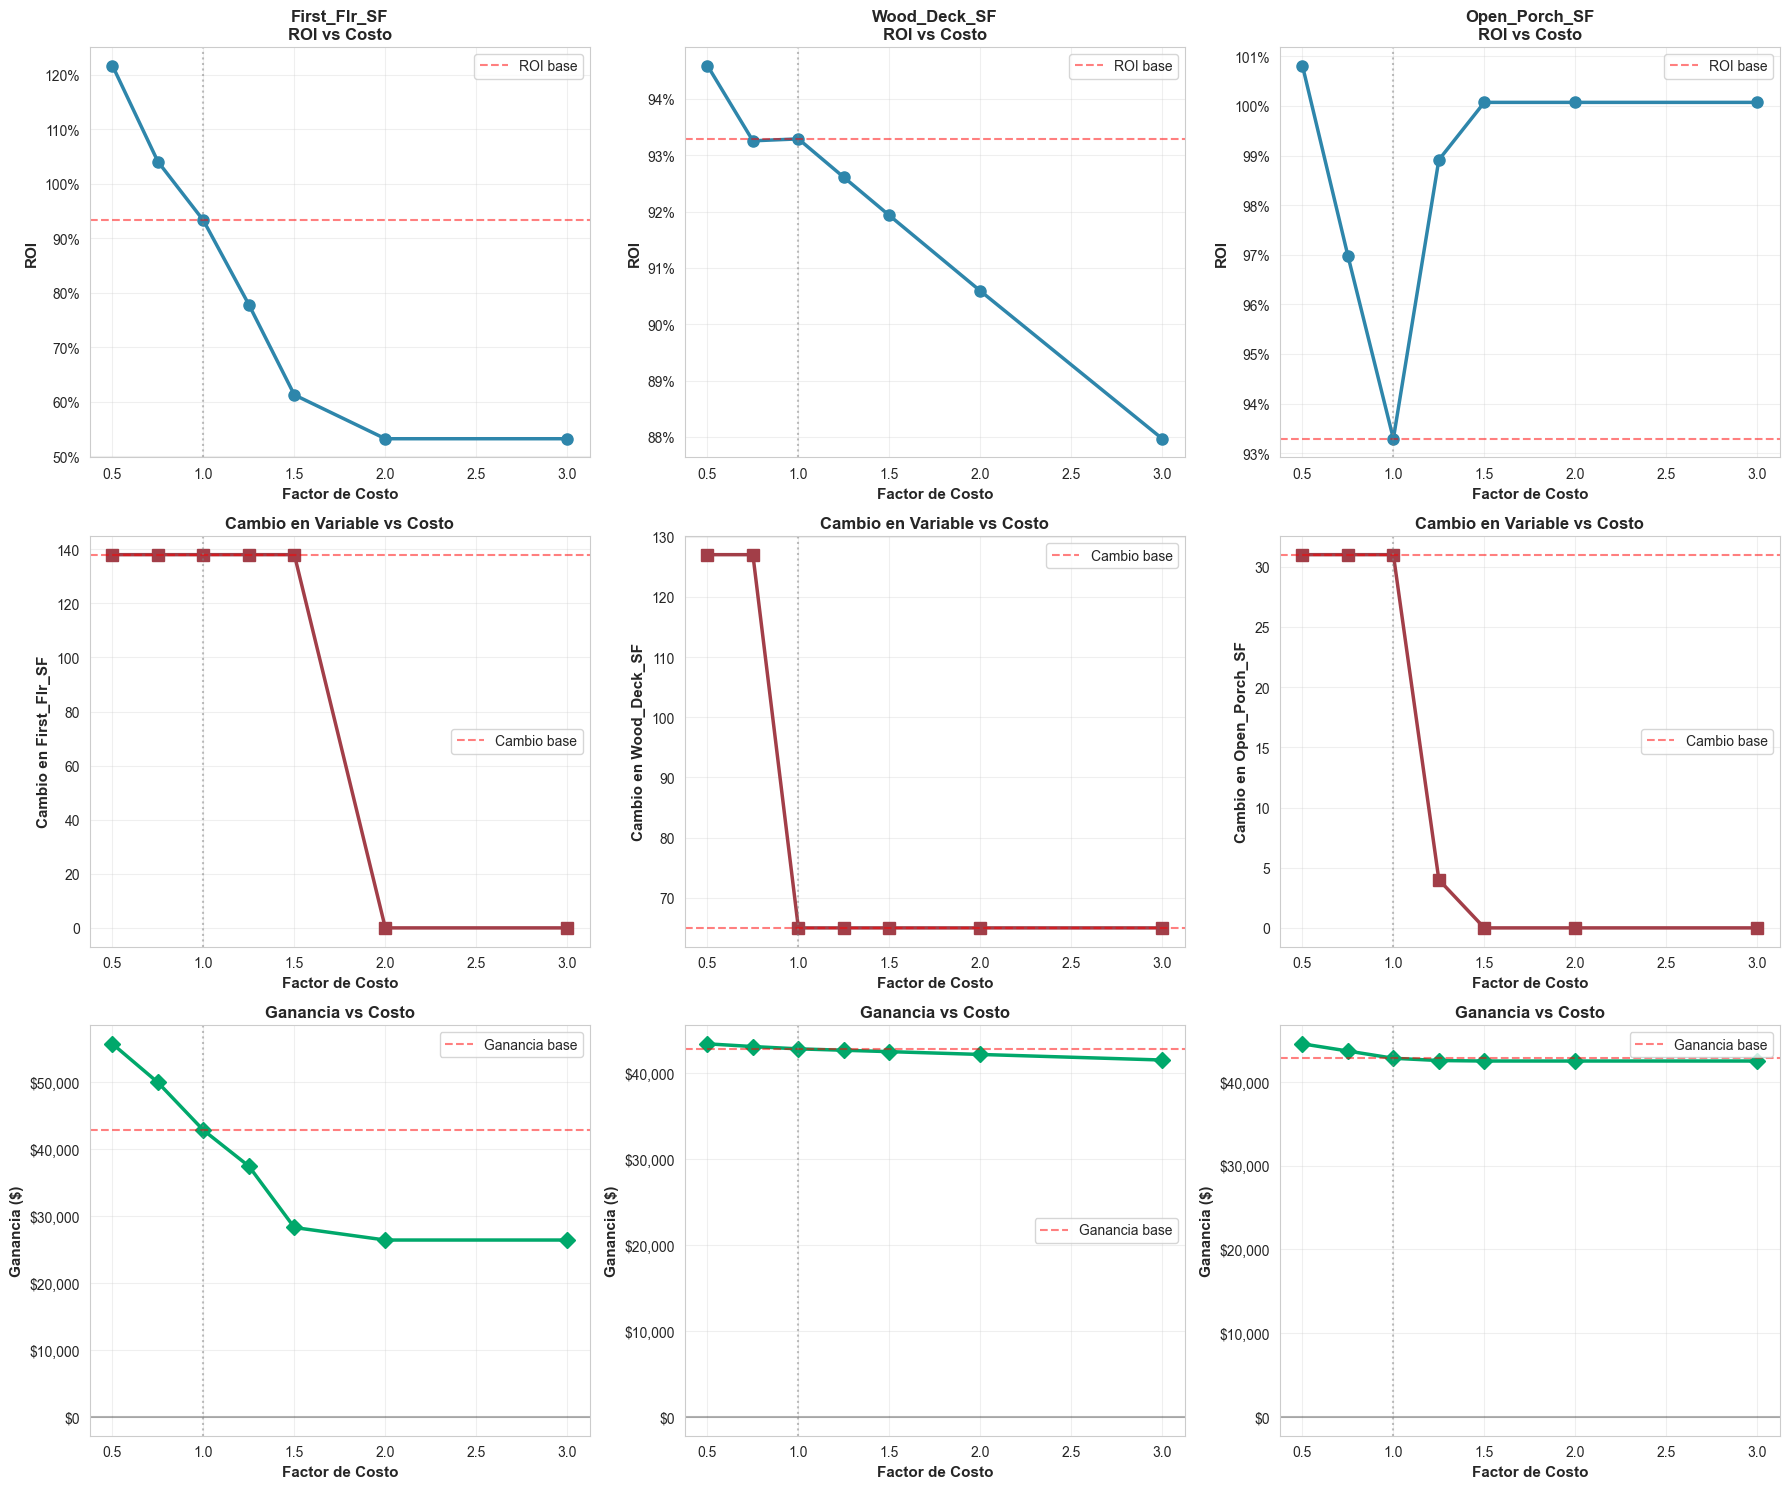

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, var in enumerate(top_vars):
    # Datos para gráficos
    factors = sorted(results_individual[var].keys())
    rois = [results_individual[var][f]['roi'] for f in factors]
    var_changes = [results_individual[var][f]['changes'].get(var, 0) for f in factors]
    profits = [results_individual[var][f]['profit'] for f in factors]
    
    # Gráfico 1: ROI vs Factor de Costo
    ax1 = axes[idx]
    ax1.plot(factors, rois, marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
    ax1.axhline(result_base['roi'], color='red', linestyle='--', alpha=0.5, label='ROI base')
    ax1.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
    ax1.set_xlabel('Factor de Costo', fontsize=11, fontweight='bold')
    ax1.set_ylabel('ROI', fontsize=11, fontweight='bold')
    ax1.set_title(f'{var}\nROI vs Costo', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    
    # Gráfico 2: Cambio de Variable vs Factor de Costo
    ax2 = axes[idx + 3]
    ax2.plot(factors, var_changes, marker='s', linewidth=2.5, markersize=8, color='#A23E48')
    ax2.axhline(result_base['changes'].get(var, 0), color='red', linestyle='--', alpha=0.5, label='Cambio base')
    ax2.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Factor de Costo', fontsize=11, fontweight='bold')
    ax2.set_ylabel(f'Cambio en {var}', fontsize=11, fontweight='bold')
    ax2.set_title(f'Cambio en Variable vs Costo', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Gráfico 3: Ganancia vs Factor de Costo
    ax3 = axes[idx + 6]
    ax3.plot(factors, profits, marker='D', linewidth=2.5, markersize=8, color='#00A86B')
    ax3.axhline(result_base['profit'], color='red', linestyle='--', alpha=0.5, label='Ganancia base')
    ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax3.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
    ax3.set_xlabel('Factor de Costo', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Ganancia ($)', fontsize=11, fontweight='bold')
    ax3.set_title(f'Ganancia vs Costo', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

## 5️⃣ Análisis de Combinaciones (2 variables)

Ahora variamos el costo de 2 variables simultáneamente

In [ ]:
# Combinaciones de 2 variables
var_combinations_2 = list(combinations(top_vars, 2))

# Factores reducidos para combinaciones
cost_factors_comb = [0.5, 1.0, 1.5, 2.0]

results_comb2 = {}

print("="*80)
print("🔬 ANÁLISIS DE COMBINACIONES (2 VARIABLES)")
print("="*80)

for var1, var2 in var_combinations_2:
    combo_name = f"{var1} + {var2}"
    results_comb2[combo_name] = {}
    
    print(f"\n{'='*80}")
    print(f"📊 Combinación: {combo_name}")
    print(f"{'='*80}")
    
    for f1 in cost_factors_comb:
        for f2 in cost_factors_comb:
            factor_key = (f1, f2)
            print(f"\n   Factores ({f1}x, {f2}x)...", end=" ")
            
            params = BASE_PARAMS.copy()
            params['custom_costs'] = {var1: f1, var2: f2}
            
            result = optimize_house(**params)
            
            if result and 'profit' in result:
                results_comb2[combo_name][factor_key] = result
                print(f"✓ ROI: {result['roi']:>6.1%}")
            else:
                print(f"✗ Error")

print(f"\n{'='*80}")
print("✅ Análisis de combinaciones (2 vars) completado")
print("="*80)

## 6️⃣ Heatmaps de Combinaciones

In [ ]:
fig, axes = plt.subplots(1, len(var_combinations_2), figsize=(18, 5))

if len(var_combinations_2) == 1:
    axes = [axes]

for idx, (var1, var2) in enumerate(var_combinations_2):
    combo_name = f"{var1} + {var2}"
    
    # Crear matriz de ROI
    roi_matrix = np.zeros((len(cost_factors_comb), len(cost_factors_comb)))
    
    for i, f1 in enumerate(cost_factors_comb):
        for j, f2 in enumerate(cost_factors_comb):
            factor_key = (f1, f2)
            if factor_key in results_comb2[combo_name]:
                roi_matrix[i, j] = results_comb2[combo_name][factor_key]['roi']
            else:
                roi_matrix[i, j] = np.nan
    
    # Heatmap
    ax = axes[idx]
    im = ax.imshow(roi_matrix, cmap='RdYlGn', aspect='auto')
    
    # Etiquetas
    ax.set_xticks(range(len(cost_factors_comb)))
    ax.set_yticks(range(len(cost_factors_comb)))
    ax.set_xticklabels([f"{f}x" for f in cost_factors_comb])
    ax.set_yticklabels([f"{f}x" for f in cost_factors_comb])
    
    ax.set_xlabel(f'{var2} (Factor)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'{var1} (Factor)', fontsize=11, fontweight='bold')
    ax.set_title(f'ROI Heatmap\n{var1} vs {var2}', fontsize=12, fontweight='bold')
    
    # Añadir valores
    for i in range(len(cost_factors_comb)):
        for j in range(len(cost_factors_comb)):
            if not np.isnan(roi_matrix[i, j]):
                text = ax.text(j, i, f'{roi_matrix[i, j]:.1%}',
                             ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax, label='ROI')

plt.tight_layout()
plt.show()

## 7️⃣ Análisis de Combinación Completa (3 variables)

Probamos algunas combinaciones clave de las 3 variables

In [ ]:
# Combinaciones clave de 3 variables
combinations_3 = [
    (0.5, 0.5, 0.5),   # Todos baratos
    (0.5, 1.0, 1.0),   # Uno barato
    (1.0, 1.0, 1.0),   # Base
    (1.5, 1.0, 1.0),   # Uno caro
    (1.5, 1.5, 1.0),   # Dos caros
    (1.5, 1.5, 1.5),   # Todos moderadamente caros
    (2.0, 1.0, 1.0),   # Uno muy caro
    (2.0, 2.0, 2.0),   # Todos muy caros
    (3.0, 1.0, 1.0),   # Uno extremadamente caro
]

results_comb3 = {}

print("="*80)
print("🔬 ANÁLISIS DE COMBINACIÓN COMPLETA (3 VARIABLES)")
print("="*80)
print(f"Variables: {top_vars[0]}, {top_vars[1]}, {top_vars[2]}")
print("="*80)

for f1, f2, f3 in combinations_3:
    factor_key = (f1, f2, f3)
    print(f"\nFactores ({f1}x, {f2}x, {f3}x)...", end=" ")
    
    params = BASE_PARAMS.copy()
    params['custom_costs'] = {
        top_vars[0]: f1,
        top_vars[1]: f2,
        top_vars[2]: f3
    }
    
    result = optimize_house(**params)
    
    if result and 'profit' in result:
        results_comb3[factor_key] = result
        print(f"✓ ROI: {result['roi']:>6.1%} | Ganancia: ${result['profit']:>10,.0f}")
    else:
        print(f"✗ Error")

print(f"\n{'='*80}")
print("✅ Análisis de 3 variables completado")
print("="*80)

## 8️⃣ Tabla Comparativa de Resultados

In [ ]:
# Crear DataFrame con todos los resultados de 3 variables
rows = []
for factor_key, result in results_comb3.items():
    f1, f2, f3 = factor_key
    rows.append({
        f'{top_vars[0]}_factor': f1,
        f'{top_vars[1]}_factor': f2,
        f'{top_vars[2]}_factor': f3,
        f'{top_vars[0]}_cambio': result['changes'].get(top_vars[0], 0),
        f'{top_vars[1]}_cambio': result['changes'].get(top_vars[1], 0),
        f'{top_vars[2]}_cambio': result['changes'].get(top_vars[2], 0),
        'Inversión': result['spent'],
        'Ganancia': result['profit'],
        'ROI': result['roi'],
        'N_Cambios': result['num_changes']
    })

df_comb3 = pd.DataFrame(rows).sort_values('ROI', ascending=False)

print("\n📊 RESULTADOS ORDENADOS POR ROI:")
print("="*120)
display(df_comb3.style.format({
    f'{top_vars[0]}_factor': '{:.1f}x',
    f'{top_vars[1]}_factor': '{:.1f}x',
    f'{top_vars[2]}_factor': '{:.1f}x',
    f'{top_vars[0]}_cambio': '{:+.2f}',
    f'{top_vars[1]}_cambio': '{:+.2f}',
    f'{top_vars[2]}_cambio': '{:+.2f}',
    'Inversión': '${:,.0f}',
    'Ganancia': '${:,.0f}',
    'ROI': '{:.2%}'
}).background_gradient(subset=['ROI'], cmap='RdYlGn'))

## 9️⃣ Análisis de Sustitución

¿Cómo cambia el uso de cada variable cuando su costo aumenta?

In [7]:
print("="*80)
print("🔄 ANÁLISIS DE SUSTITUCIÓN DE VARIABLES")
print("="*80)

for var in top_vars:
    print(f"\n{'='*80}")
    print(f"📌 Variable: {var}")
    print(f"{'='*80}")
    print(f"\n{'Factor':>8} | {'Cambio en Var':>15} | {'ROI':>8} | {'Top 3 Cambios Alternativos'}")
    print("-"*80)
    
    for factor in sorted(results_individual[var].keys()):
        result = results_individual[var][factor]
        var_change = result['changes'].get(var, 0)
        roi = result['roi']
        
        # Encontrar top 3 cambios alternativos (excluyendo la variable analizada)
        other_changes = {k: abs(v) for k, v in result['changes'].items() 
                        if k != var and abs(v) > 0.01}
        top_3_others = sorted(other_changes.items(), key=lambda x: x[1], reverse=True)[:3]
        
        alternatives = ", ".join([f"{k[:15]}:{v:+.1f}" for k, v in top_3_others])
        
        print(f"{factor:>7.1f}x | {var_change:>+15.2f} | {roi:>7.1%} | {alternatives}")
    
    print()

print("="*80)

🔄 ANÁLISIS DE SUSTITUCIÓN DE VARIABLES

📌 Variable: First_Flr_SF

  Factor |   Cambio en Var |      ROI | Top 3 Cambios Alternativos
--------------------------------------------------------------------------------
    0.5x |         +138.00 |  121.7% | Garage_Area:+154.0, Wood_Deck_SF:+65.0, Open_Porch_SF:+31.0
    0.8x |         +138.00 |  104.1% | Garage_Area:+154.0, Wood_Deck_SF:+65.0, Year_Remod_Add:+22.0
    1.0x |         +138.00 |   93.3% | Wood_Deck_SF:+65.0, Open_Porch_SF:+31.0, Year_Remod_Add:+22.0
    1.2x |         +138.00 |   77.8% | Wood_Deck_SF:+65.0, Year_Remod_Add:+22.0, Garage_Area:+7.0
    1.5x |         +138.00 |   61.3% | Wood_Deck_SF:+65.0, Year_Remod_Add:+22.0, Garage_Area:+4.0
    2.0x |           +0.00 |   53.2% | Second_Flr_SF:+138.0, Wood_Deck_SF:+65.0, Year_Remod_Add:+22.0
    3.0x |           +0.00 |   53.2% | Second_Flr_SF:+138.0, Wood_Deck_SF:+65.0, Year_Remod_Add:+22.0


📌 Variable: Wood_Deck_SF

  Factor |   Cambio en Var |      ROI | Top 3 Cambios Alte

## 🔍 Análisis de Punto de Quiebre

¿Existe un precio donde el modelo finalmente deja de usar estas variables?

## 🏆 Resumen Ejecutivo

In [ ]:
print("="*80)
print("🏆 RESUMEN EJECUTIVO - ANÁLISIS DE SENSIBILIDAD DE COSTOS")
print("="*80)

print(f"\n🏠 Casa analizada: #{casa_idx}")
print(f"   Precio original: ${np.expm1(y_log.iloc[casa_idx]):,.0f}")

print(f"\n📊 ESCENARIO BASE (sin modificar costos):")
print(f"   Inversión: ${result_base['spent']:,.0f}")
print(f"   Ganancia:  ${result_base['profit']:,.0f}")
print(f"   ROI:       {result_base['roi']:.2%}")

print(f"\n🎯 TOP 3 VARIABLES MÁS MODIFICADAS:")
for i, var in enumerate(top_vars, 1):
    change = result_base['changes'][var]
    cost = result_base['cost_breakdown'].get(var, 0)
    print(f"   {i}. {var}: {change:+.2f} unidades (${cost:,.0f})")

print(f"\n💡 INSIGHTS PRINCIPALES:")

# 1. Variable más sensible al costo
print(f"\n1️⃣  SENSIBILIDAD AL COSTO:")
for var in top_vars:
    # Comparar cambio en la variable entre factor 0.5x y 2.0x
    if 0.5 in results_individual[var] and 2.0 in results_individual[var]:
        change_cheap = results_individual[var][0.5]['changes'].get(var, 0)
        change_expensive = results_individual[var][2.0]['changes'].get(var, 0)
        sensitivity = abs(change_cheap - change_expensive)
        print(f"   • {var}: Diferencia de {sensitivity:.2f} unidades entre 0.5x y 2.0x")

# 2. Mejor escenario
best_combo = df_comb3.iloc[0]
print(f"\n2️⃣  MEJOR COMBINACIÓN DE COSTOS:")
print(f"   Factores: {best_combo[f'{top_vars[0]}_factor']:.1f}x, {best_combo[f'{top_vars[1]}_factor']:.1f}x, {best_combo[f'{top_vars[2]}_factor']:.1f}x")
print(f"   ROI: {best_combo['ROI']:.2%}")
print(f"   Ganancia: ${best_combo['Ganancia']:,.0f}")

# 3. Peor escenario
worst_combo = df_comb3.iloc[-1]
print(f"\n3️⃣  PEOR COMBINACIÓN DE COSTOS:")
print(f"   Factores: {worst_combo[f'{top_vars[0]}_factor']:.1f}x, {worst_combo[f'{top_vars[1]}_factor']:.1f}x, {worst_combo[f'{top_vars[2]}_factor']:.1f}x")
print(f"   ROI: {worst_combo['ROI']:.2%}")
print(f"   Ganancia: ${worst_combo['Ganancia']:,.0f}")

print(f"\n{'='*80}")

## 📊 Elasticidad de las Variables

Calculamos la elasticidad: ¿cuánto cambia el uso ante cambios en el costo?

In [ ]:
print("="*80)
print("📊 CÁLCULO DE ELASTICIDAD")
print("="*80)
print("\nElasticidad = % cambio en cantidad / % cambio en precio")
print("   < 0.5  : Inelástica (insensible al precio)")
print("   0.5-1.5: Moderada")
print("   > 1.5  : Elástica (muy sensible al precio)")
print("="*80)

for var in top_vars:
    print(f"\n📌 {var}")
    print("-"*80)
    
    # Comparar entre factor 1.0x y 2.0x
    if 1.0 in results_individual[var] and 2.0 in results_individual[var]:
        q_base = abs(results_individual[var][1.0]['changes'].get(var, 0))
        q_expensive = abs(results_individual[var][2.0]['changes'].get(var, 0))
        
        # Cambio porcentual en cantidad
        if q_base > 0:
            pct_change_quantity = ((q_expensive - q_base) / q_base) * 100
        else:
            pct_change_quantity = 0
        
        # Cambio porcentual en precio (100% porque va de 1x a 2x)
        pct_change_price = 100
        
        # Elasticidad
        if pct_change_price != 0:
            elasticity = abs(pct_change_quantity / pct_change_price)
        else:
            elasticity = 0
        
        # Clasificación
        if elasticity < 0.5:
            classification = "INELÁSTICA ⚡"
        elif elasticity < 1.5:
            classification = "MODERADA 📊"
        else:
            classification = "ELÁSTICA 📉"
        
        print(f"   Cantidad a 1.0x:  {q_base:>10.2f}")
        print(f"   Cantidad a 2.0x:  {q_expensive:>10.2f}")
        print(f"   Cambio cantidad:  {pct_change_quantity:>10.1f}%")
        print(f"   Elasticidad:      {elasticity:>10.4f}")
        print(f"   Clasificación:    {classification}")
        
        # Insight
        if elasticity < 0.01:
            print(f"\n   💡 Esta variable es CRÍTICA - el modelo la usa igual sin importar el costo")
        elif elasticity < 0.5:
            print(f"\n   💡 Variable importante - poco sensible al precio")
        else:
            print(f"\n   💡 Variable flexible - el modelo ajusta su uso según el costo")

print("\n" + "="*80)

## 💰 Análisis Costo-Beneficio Marginal

¿Cuánto valor genera cada dólar invertido en cada variable?

In [ ]:
print("="*80)
print("💰 VALOR MARGINAL POR DÓLAR INVERTIDO")
print("="*80)

for var in top_vars:
    print(f"\n📌 {var}")
    print("-"*80)
    print(f"{'Factor':>8} | {'Costo':>12} | {'Beneficio':>12} | {'$/Beneficio':>12} | {'Eficiencia'}")
    print("-"*80)
    
    base_profit = result_base['profit']
    
    for factor in [0.5, 1.0, 1.5, 2.0, 3.0]:
        if factor in results_individual[var]:
            result = results_individual[var][factor]
            
            # Costo de esta variable específica
            var_cost = abs(result['cost_breakdown'].get(var, 0))
            
            # Beneficio total
            profit = result['profit']
            
            # Eficiencia: beneficio por cada dólar invertido en esta variable
            if var_cost > 0:
                efficiency = profit / var_cost
                efficiency_str = f"${efficiency:.2f}/$ invertido"
            else:
                efficiency = 0
                efficiency_str = "N/A"
            
            print(f"{factor:>7.1f}x | ${var_cost:>10,.0f} | ${profit:>10,.0f} | ${var_cost:>10,.0f} | {efficiency_str}")
    
    print()

print("="*80)
print("💡 INTERPRETACIÓN:")
print("   - Mayor eficiencia = más valor por dólar invertido en esa variable")
print("   - Si eficiencia baja al aumentar costo = sensible al precio")
print("   - Si eficiencia se mantiene = variable crítica independiente del costo")
print("="*80)